In [1]:

import sys
import shap 
import pickle
import sklearn 
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from types import SimpleNamespace



In [216]:



sys.path.append("../")

from dd_package.data.dyslexia_data import DyslexiaData
from dd_package.data.preprocess import preprocess_data

from dd_package.models.regression_estimators import RegressionEstimators

from dd_package.common.utils import save_a_dict, load_a_dict, print_the_evaluated_results

from dd_package.data.preprocess import minmax_standardizer_



In [3]:

configs = {
    "models_path": Path("/home/soroosh/Programmes/DD/Models"),
    "results_path": Path("/home/soroosh/Programmes/DD/Results"),
    "figures_path": Path("/home/soroosh/Programmes/DD/Figures"),
    "params_path": Path("/home/soroosh/Programmes/DD//Params"),
    "n_repeats": 10,
    "n_splits": 5,
}

configs = SimpleNamespace(**configs)



In [4]:

data_name="dd_fix_demo"

estimator_name = "mlp_cls"
to_shuffle = True
to_exclude_at_risk = 0




In [5]:

specifier = data_name + "-" + estimator_name + \
"--shuffled:" + str(to_shuffle) + \
"--exclude at risk:" + str(to_exclude_at_risk)



In [6]:
configs.specifier = specifier
configs.data_name = data_name



In [7]:

configs.specifier



'dd_fix_demo-mlp_cls--shuffled:True--exclude at risk:0'

# demo-Fcls-mm:

- Chosen model: **MLP**



## Load Data

In [8]:


dd = DyslexiaData(path="../../datasets/", n_repeats=5)



In [17]:


if data_name == "dd_demo":
    # dict of dicts, s.t each dict contains pd.df of a class, e.g normal
    _ = dd.get_demo_datasets()  # demos and phonological (which is initially part of demo)
    demo_phono = dd.concat_classes_demo()

    # The optimize way to exclude at-risk class
    if to_exclude_at_risk == 1:
        to_exclude_at_risk = True
        demo_phono = demo_phono.loc[demo_phono.Group != 2]

    df_data_to_use = demo_phono.loc[:, [
                                           'Group', 'SubjectID', 'Sex', 'Grade', 'Age', 'IQ', 'Reading_speed',
                                       ]]
    c_features = ['Sex', 'Grade', ]
    indicators = ['SubjectID', ]
    targets = ["Group", "Reading_speed", ]

elif data_name == "dd_fix_demo":
    # dict of dicts, s.t each dict contains pd.df of a class, e.g normal
    _ = dd.get_demo_datasets()  # demos
    _ = dd.get_fix_datasets()  # fixes

    # concatenate pd.dfs to a pd.df
    fix = dd.concat_classes_fix()
    demo_phono = dd.concat_classes_demo()

    # The optimize way to exclude at-risk class
    if to_exclude_at_risk == 1:
        to_exclude_at_risk = True
        fix = fix.loc[fix.Group != 2]
        demo_phono = demo_phono.loc[demo_phono.Group != 2]

    fix_demo = dd.concat_dfs(
        df1=fix,
        df2=demo_phono,
        features1=fix.columns,
        features2=[
            "Sex", "Grade", "Age", "IQ", "Reading_speed",
        ],
    )

    df_data_to_use = fix_demo
    c_features = ['Sex', 'Grade', ]
    indicators = [
        'SubjectID', 'Sentence_ID', 'Word_Number',
    ]

    targets = ["Group", "Reading_speed", ]
    
elif data_name == "dd_fix":

    # dict of dicts, s.t each dict contains pd.df of a class, e.g normal
    _ = dd.get_fix_datasets()  # fixes
    # concatenate pd.dfs to a pd.df
    fix = dd.concat_classes_fix()

    # The optimize way to exclude at-risk class
    if to_exclude_at_risk == 1:
        to_exclude_at_risk = True
        fix = fix.loc[fix.Group != 2]

    df_data_to_use = fix
    c_features = None
    indicators = [
        'SubjectID', 'Sentence_ID', 'Word_Number',
    ]

    targets = ["Group", ]
    
    

Loading Demo data: 
  dyslexia (72, 9)
  norm (213, 9)
  risk (22, 9)
 
Loading Fixation report data:
  dyslexia (59770, 7)
  norm (139507, 7)
  risk (26073, 7)
 


In [499]:

df_data_to_use.head()



,Group,SubjectID,Sentence_ID,Word_Number,FIX_X,FIX_Y,FIX_DURATION,Sex,Grade,Age,IQ,Reading_speed
0,1,10,4,1,177.3,531.8,219.0,1,4,10,23,102.0
1,1,10,4,2,200.5,545.2,247.0,1,4,10,23,102.0
2,1,10,4,3,282.7,542.4,261.0,1,4,10,23,102.0
3,1,10,4,4,358.1,545.5,268.0,1,4,10,23,102.0
4,1,10,4,4,392.8,536.3,129.0,1,4,10,23,102.0


In [501]:


x_org, y_org = dd.get_onehot_features_targets(
    data=df_data_to_use,
    c_features=c_features,
    indicators=indicators,
    targets=targets,
)



In [502]:

x_org.head()



,Sex_2,Grade_4,FIX_DURATION,FIX_X,IQ,FIX_Y,Sex_1,Age,Grade_2,Grade_3,Grade_5,Grade_6,Grade_1
0,0,1,219.0,177.3,23,531.8,1,10,0,0,0,0,0
1,0,1,247.0,200.5,23,545.2,1,10,0,0,0,0,0
2,0,1,261.0,282.7,23,542.4,1,10,0,0,0,0,0
3,0,1,268.0,358.1,23,545.5,1,10,0,0,0,0,0
4,0,1,129.0,392.8,23,536.3,1,10,0,0,0,0,0


In [503]:

y_org.head()



,Group,Reading_speed
0,1,102.0
1,1,102.0
2,1,102.0
3,1,102.0
4,1,102.0


In [23]:


estimator_name = "MLP_cls"

if estimator_name.split("_")[-1] == "reg":
    learning_method = "regression"
    y = y_org.Reading_speed.values

elif estimator_name.split("_")[-1] == "cls":
    learning_method = "classification"
    y = y_org.Group.values

elif estimator_name.split("_")[-1] == "clu":
    from dd_package.models.clustering_estimators import ClusteringEstimators
    y = y_org.Group.values
else:
    assert False, "Undefined algorithm and thus undefined target values"
    
print("learning_method:", learning_method)



learning_method: classification


In [24]:

x = preprocess_data(x=x_org, pp="mm")  # only x is standardized



pre-processing: mm
Preprocessed data shape: (225350, 13)


In [25]:

data = dd.get_stratified_train_test_splits(
        x=x, y=y,
        labels=y_org.Group.values,
        to_shuffle=to_shuffle,
        n_splits=10
    )



In [26]:

data


defaultdict(collections.defaultdict,
            {'1': defaultdict(list,
                         {'x_train': array([[0.   , 1.   , 0.022, ..., 0.   , 0.   , 0.   ],
                                 [0.   , 1.   , 0.025, ..., 0.   , 0.   , 0.   ],
                                 [0.   , 1.   , 0.027, ..., 0.   , 0.   , 0.   ],
                                 ...,
                                 [1.   , 0.   , 0.02 , ..., 0.   , 0.   , 0.   ],
                                 [1.   , 0.   , 0.015, ..., 0.   , 0.   , 0.   ],
                                 [1.   , 0.   , 0.019, ..., 0.   , 0.   , 0.   ]]),
                          'x_test': array([[0.   , 1.   , 0.026, ..., 0.   , 0.   , 0.   ],
                                 [0.   , 1.   , 0.02 , ..., 0.   , 0.   , 0.   ],
                                 [0.   , 1.   , 0.018, ..., 0.   , 0.   , 0.   ],
                                 ...,
                                 [1.   , 0.   , 0.037, ..., 0.   , 0.   , 0.   ],
        

## Load the tuned parameters

In [161]:

tuned_params = load_a_dict(
    name=configs.specifier,
    save_path=configs.params_path
        )
tuned_params



OrderedDict([('activation', 'tanh'),
             ('hidden_layer_sizes', 158),
             ('max_iter', 49150),
             ('solver', 'lbfgs')])

In [504]:


specifier



'dd_fix_demo-mlp_cls--shuffled:True--exclude at risk:0'

In [ ]:
# save_a_dict(a_dict=tuned_params,
#             name='dd_fix_demo-mlp_reg--shuffled:True--exclude at risk:0',
#             save_path=configs.params_path,
#            )

In [29]:

mdl = sklearn.neural_network.MLPClassifier(
    activation=tuned_params["activation"], 
    hidden_layer_sizes=tuned_params["hidden_layer_sizes"],
    max_iter=tuned_params["max_iter"],
    solver=tuned_params["solver"],
    verbose=1
)

mdl




MLPClassifier(activation='tanh', hidden_layer_sizes=158, max_iter=49150,
              solver='lbfgs', verbose=1)

In [49]:
x_train = data["6"]["x_train"]
tmp_x_test = data["6"]["x_test"]
y_train = data["6"]["y_train"]
tmp_y_test = data["6"]["y_test"]



In [31]:

class_names = ['Norm', 'At-risk', 'Dyslexic']




## Previously obtained results

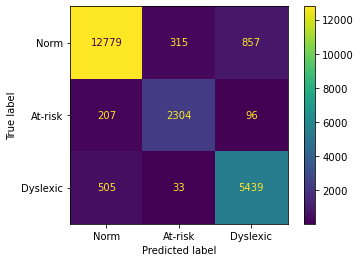

Kappa: 0.8347400437872468 AUC ROC: 0.9825072610728137


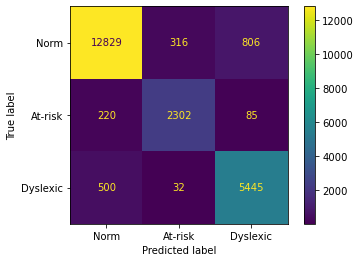

Kappa: 0.8388978522946917 AUC ROC: 0.9829182453627607


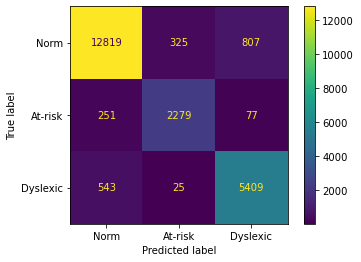

Kappa: 0.832869081391151 AUC ROC: 0.9823166765651608


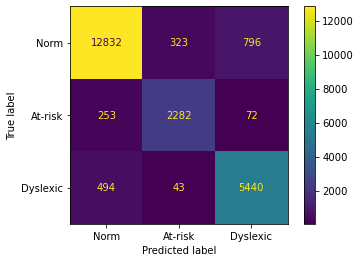

Kappa: 0.8369422822490217 AUC ROC: 0.9828148640073884


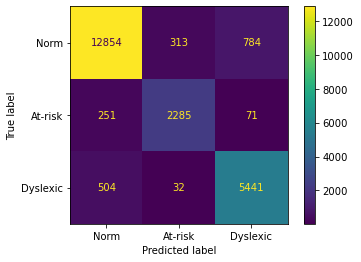

Kappa: 0.8389059114142479 AUC ROC: 0.9829848306845811


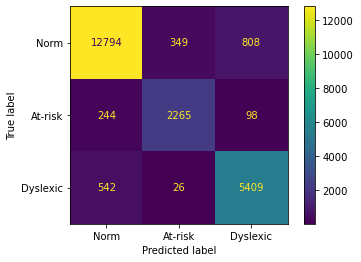

Kappa: 0.829841840423335 AUC ROC: 0.9823257928381303


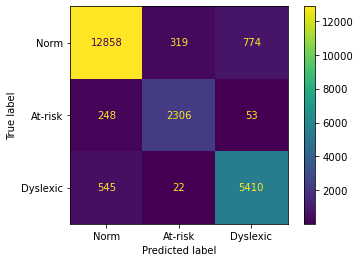

Kappa: 0.8382473045222396 AUC ROC: 0.9827749230027788


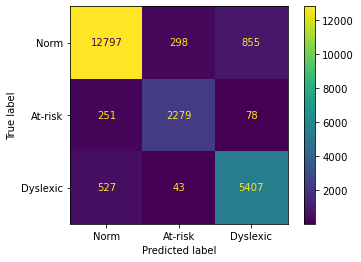

Kappa: 0.8310664313696852 AUC ROC: 0.9821932698756151


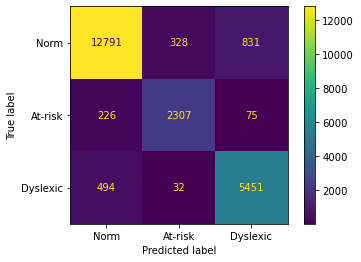

Kappa: 0.8368983636632326 AUC ROC: 0.9830666923198533


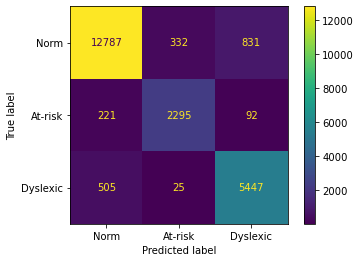

Kappa: 0.8352159256796329 AUC ROC: 0.9824885993933525


In [54]:

results = load_a_dict(
    name=configs.specifier,
    save_path=configs.results_path,
        )




for i in range(1, 11):
    i = str(i)
    y_test_ = results[i]["y_test"]
    y_pred_ = results[i]["y_pred"]
    y_prob_ = results[i]["y_pred_prob"]
    
    cm = sklearn.metrics.confusion_matrix(
    y_true=y_test_, 
    y_pred=y_pred_
    )
    
    disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=class_names
                             )
    disp.plot()
    plt.show()
    
    
    print(
        "Kappa:", sklearn.metrics.cohen_kappa_score(y1=y_test_, y2=y_pred_),
        
        "AUC ROC:", sklearn.metrics.roc_auc_score(y_test_, y_prob_,
                                                  multi_class="ovr",
                                                  average="weighted")
    )





In [56]:


print_the_evaluated_results(
    results=results, 
    learning_method=learning_method
)



  ari    nmi  	 preci 	 recall  	 f1_score  	 roc_auc  	 meape  	 jsd  	 acc
 Ave   std  Ave   std   Ave   std   Ave   std   Ave   std   Ave   std   Ave   std   Ave   std   Ave   std 
0.730 0.004 0.631 0.005 0.913 0.002 0.911 0.002 0.912 0.002 0.983 0.000 1.960 0.018 0.103 0.001 0.911 0.002


In [57]:


mdl.fit(x_train, y_train)



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         2689     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.81083D-01    |proj g|=  1.39356D-01


 This problem is unconstrained.



At iterate    1    f=  9.04099D-01    |proj g|=  4.81611D-02

At iterate    2    f=  8.81755D-01    |proj g|=  2.30960D-02

At iterate    3    f=  8.54403D-01    |proj g|=  4.48799D-02

At iterate    4    f=  8.36626D-01    |proj g|=  3.26220D-02

At iterate    5    f=  8.13578D-01    |proj g|=  7.16631D-03

At iterate    6    f=  8.07033D-01    |proj g|=  6.22330D-03

At iterate    7    f=  8.02285D-01    |proj g|=  6.29227D-03

At iterate    8    f=  7.96723D-01    |proj g|=  5.92686D-03

At iterate    9    f=  7.93593D-01    |proj g|=  8.05904D-03

At iterate   10    f=  7.92049D-01    |proj g|=  4.06626D-03

At iterate   11    f=  7.90925D-01    |proj g|=  2.00343D-03

At iterate   12    f=  7.89886D-01    |proj g|=  1.15374D-02

At iterate   13    f=  7.88940D-01    |proj g|=  4.03961D-03

At iterate   14    f=  7.88353D-01    |proj g|=  2.64696D-03

At iterate   15    f=  7.87012D-01    |proj g|=  3.34096D-03

At iterate   16    f=  7.85087D-01    |proj g|=  3.83814D-03

At iter


At iterate  134    f=  6.49212D-01    |proj g|=  2.29781D-02

At iterate  135    f=  6.47458D-01    |proj g|=  1.26771D-02

At iterate  136    f=  6.46167D-01    |proj g|=  9.86231D-03

At iterate  137    f=  6.45103D-01    |proj g|=  1.49253D-02

At iterate  138    f=  6.44185D-01    |proj g|=  1.07790D-02

At iterate  139    f=  6.42656D-01    |proj g|=  1.72185D-02

At iterate  140    f=  6.39981D-01    |proj g|=  1.53526D-02

At iterate  141    f=  6.38217D-01    |proj g|=  1.52685D-02

At iterate  142    f=  6.36959D-01    |proj g|=  1.24849D-02

At iterate  143    f=  6.35742D-01    |proj g|=  2.81870D-02

At iterate  144    f=  6.33855D-01    |proj g|=  1.09016D-02

At iterate  145    f=  6.33077D-01    |proj g|=  8.11766D-03

At iterate  146    f=  6.32411D-01    |proj g|=  9.76794D-03

At iterate  147    f=  6.30985D-01    |proj g|=  1.26821D-02

At iterate  148    f=  6.29672D-01    |proj g|=  1.92974D-02

At iterate  149    f=  6.28313D-01    |proj g|=  9.18224D-03

At iter


At iterate  267    f=  5.37626D-01    |proj g|=  1.34487D-02

At iterate  268    f=  5.37208D-01    |proj g|=  7.96863D-03

At iterate  269    f=  5.37095D-01    |proj g|=  8.09263D-03

At iterate  270    f=  5.36745D-01    |proj g|=  6.83568D-03

At iterate  271    f=  5.36138D-01    |proj g|=  9.10507D-03

At iterate  272    f=  5.35672D-01    |proj g|=  8.42668D-03

At iterate  273    f=  5.35287D-01    |proj g|=  1.00303D-02

At iterate  274    f=  5.34777D-01    |proj g|=  9.47504D-03

At iterate  275    f=  5.34136D-01    |proj g|=  6.51729D-03

At iterate  276    f=  5.32993D-01    |proj g|=  6.88031D-03

At iterate  277    f=  5.31734D-01    |proj g|=  1.27836D-02

At iterate  278    f=  5.30615D-01    |proj g|=  1.06795D-02

At iterate  279    f=  5.30234D-01    |proj g|=  1.69422D-02

At iterate  280    f=  5.29773D-01    |proj g|=  9.64233D-03

At iterate  281    f=  5.29421D-01    |proj g|=  8.10229D-03

At iterate  282    f=  5.29019D-01    |proj g|=  6.38391D-03

At iter


At iterate  400    f=  4.57130D-01    |proj g|=  7.36845D-03

At iterate  401    f=  4.56532D-01    |proj g|=  6.59281D-03

At iterate  402    f=  4.56239D-01    |proj g|=  2.05029D-02

At iterate  403    f=  4.55478D-01    |proj g|=  9.18299D-03

At iterate  404    f=  4.55180D-01    |proj g|=  8.64359D-03

At iterate  405    f=  4.54389D-01    |proj g|=  6.28177D-03

At iterate  406    f=  4.53204D-01    |proj g|=  6.74511D-03

At iterate  407    f=  4.52383D-01    |proj g|=  9.06362D-03

At iterate  408    f=  4.51525D-01    |proj g|=  7.64342D-03

At iterate  409    f=  4.51019D-01    |proj g|=  5.36224D-03

At iterate  410    f=  4.50402D-01    |proj g|=  6.02772D-03

At iterate  411    f=  4.49496D-01    |proj g|=  1.36044D-02

At iterate  412    f=  4.48140D-01    |proj g|=  9.28116D-03

At iterate  413    f=  4.46752D-01    |proj g|=  8.03602D-03

At iterate  414    f=  4.46099D-01    |proj g|=  1.96048D-02

At iterate  415    f=  4.45169D-01    |proj g|=  7.18864D-03

At iter


At iterate  533    f=  3.94007D-01    |proj g|=  9.67831D-03

At iterate  534    f=  3.93634D-01    |proj g|=  8.55380D-03

At iterate  535    f=  3.93023D-01    |proj g|=  8.20661D-03

At iterate  536    f=  3.92482D-01    |proj g|=  8.76882D-03

At iterate  537    f=  3.91976D-01    |proj g|=  5.99325D-03

At iterate  538    f=  3.91635D-01    |proj g|=  8.52283D-03

At iterate  539    f=  3.91349D-01    |proj g|=  5.94702D-03

At iterate  540    f=  3.91046D-01    |proj g|=  4.71531D-03

At iterate  541    f=  3.90626D-01    |proj g|=  1.25682D-02

At iterate  542    f=  3.90102D-01    |proj g|=  7.47109D-03

At iterate  543    f=  3.89702D-01    |proj g|=  6.97997D-03

At iterate  544    f=  3.89144D-01    |proj g|=  7.39901D-03

At iterate  545    f=  3.88609D-01    |proj g|=  5.52981D-03

At iterate  546    f=  3.87943D-01    |proj g|=  1.04740D-02

At iterate  547    f=  3.87574D-01    |proj g|=  1.18667D-02

At iterate  548    f=  3.87012D-01    |proj g|=  6.33380D-03

At iter


At iterate  666    f=  3.50110D-01    |proj g|=  3.97884D-03

At iterate  667    f=  3.49847D-01    |proj g|=  3.27226D-03

At iterate  668    f=  3.49638D-01    |proj g|=  1.07639D-02

At iterate  669    f=  3.49448D-01    |proj g|=  1.26581D-02

At iterate  670    f=  3.49330D-01    |proj g|=  7.03502D-03

At iterate  671    f=  3.49230D-01    |proj g|=  4.22314D-03

At iterate  672    f=  3.49067D-01    |proj g|=  6.86647D-03

At iterate  673    f=  3.48765D-01    |proj g|=  9.54843D-03

At iterate  674    f=  3.48379D-01    |proj g|=  7.53166D-03

At iterate  675    f=  3.48314D-01    |proj g|=  1.34504D-02

At iterate  676    f=  3.47772D-01    |proj g|=  5.68466D-03

At iterate  677    f=  3.47612D-01    |proj g|=  4.86926D-03

At iterate  678    f=  3.47388D-01    |proj g|=  6.41545D-03

At iterate  679    f=  3.47064D-01    |proj g|=  1.00632D-02

At iterate  680    f=  3.46771D-01    |proj g|=  1.27466D-02

At iterate  681    f=  3.46514D-01    |proj g|=  5.15264D-03

At iter


At iterate  799    f=  3.13967D-01    |proj g|=  8.86583D-03

At iterate  800    f=  3.13735D-01    |proj g|=  3.37058D-02

At iterate  801    f=  3.13035D-01    |proj g|=  9.82702D-03

At iterate  802    f=  3.12753D-01    |proj g|=  6.37743D-03

At iterate  803    f=  3.12530D-01    |proj g|=  1.45212D-02

At iterate  804    f=  3.12344D-01    |proj g|=  1.12505D-02

At iterate  805    f=  3.12136D-01    |proj g|=  8.77589D-03

At iterate  806    f=  3.11673D-01    |proj g|=  6.43400D-03

At iterate  807    f=  3.11436D-01    |proj g|=  5.99679D-03

At iterate  808    f=  3.11010D-01    |proj g|=  8.52687D-03

At iterate  809    f=  3.10730D-01    |proj g|=  1.30193D-02

At iterate  810    f=  3.10396D-01    |proj g|=  6.09663D-03

At iterate  811    f=  3.10047D-01    |proj g|=  5.44852D-03

At iterate  812    f=  3.09719D-01    |proj g|=  6.32139D-03

At iterate  813    f=  3.09261D-01    |proj g|=  1.16368D-02

At iterate  814    f=  3.08927D-01    |proj g|=  1.48031D-02

At iter


At iterate  932    f=  2.73755D-01    |proj g|=  8.91987D-03

At iterate  933    f=  2.73398D-01    |proj g|=  6.09199D-03

At iterate  934    f=  2.72985D-01    |proj g|=  1.17398D-02

At iterate  935    f=  2.72698D-01    |proj g|=  1.04660D-02

At iterate  936    f=  2.72466D-01    |proj g|=  7.72213D-03

At iterate  937    f=  2.72289D-01    |proj g|=  6.55995D-03

At iterate  938    f=  2.71928D-01    |proj g|=  7.51779D-03

At iterate  939    f=  2.71599D-01    |proj g|=  4.63987D-03

At iterate  940    f=  2.71347D-01    |proj g|=  3.94286D-03

At iterate  941    f=  2.71286D-01    |proj g|=  1.76552D-02

At iterate  942    f=  2.70764D-01    |proj g|=  6.73231D-03

At iterate  943    f=  2.70487D-01    |proj g|=  3.73351D-03

At iterate  944    f=  2.70219D-01    |proj g|=  6.21205D-03

At iterate  945    f=  2.69775D-01    |proj g|=  9.97527D-03

At iterate  946    f=  2.69457D-01    |proj g|=  1.28458D-02

At iterate  947    f=  2.68972D-01    |proj g|=  6.51178D-03

At iter


At iterate 1065    f=  2.47742D-01    |proj g|=  5.28261D-03

At iterate 1066    f=  2.47656D-01    |proj g|=  1.12187D-02

At iterate 1067    f=  2.47479D-01    |proj g|=  6.46331D-03

At iterate 1068    f=  2.47260D-01    |proj g|=  7.24064D-03

At iterate 1069    f=  2.47072D-01    |proj g|=  1.10749D-02

At iterate 1070    f=  2.46894D-01    |proj g|=  8.47124D-03

At iterate 1071    f=  2.46710D-01    |proj g|=  4.69338D-03

At iterate 1072    f=  2.46560D-01    |proj g|=  8.32373D-03

At iterate 1073    f=  2.46431D-01    |proj g|=  6.54172D-03

At iterate 1074    f=  2.46335D-01    |proj g|=  5.37382D-03

At iterate 1075    f=  2.46188D-01    |proj g|=  3.97288D-03

At iterate 1076    f=  2.46055D-01    |proj g|=  4.14500D-03

At iterate 1077    f=  2.45765D-01    |proj g|=  9.58126D-03

At iterate 1078    f=  2.45662D-01    |proj g|=  1.35360D-02

At iterate 1079    f=  2.45393D-01    |proj g|=  4.35637D-03

At iterate 1080    f=  2.45270D-01    |proj g|=  3.40482D-03

At iter


At iterate 1198    f=  2.32569D-01    |proj g|=  4.04437D-03

At iterate 1199    f=  2.32530D-01    |proj g|=  6.57424D-03

At iterate 1200    f=  2.32490D-01    |proj g|=  3.05135D-03

At iterate 1201    f=  2.32461D-01    |proj g|=  2.00487D-03

At iterate 1202    f=  2.32405D-01    |proj g|=  3.25091D-03

At iterate 1203    f=  2.32302D-01    |proj g|=  4.44405D-03

At iterate 1204    f=  2.32191D-01    |proj g|=  7.15298D-03

At iterate 1205    f=  2.32114D-01    |proj g|=  5.18223D-03

At iterate 1206    f=  2.32035D-01    |proj g|=  3.09505D-03

At iterate 1207    f=  2.31976D-01    |proj g|=  3.66009D-03

At iterate 1208    f=  2.31916D-01    |proj g|=  3.97823D-03

At iterate 1209    f=  2.31877D-01    |proj g|=  6.58728D-03

At iterate 1210    f=  2.31796D-01    |proj g|=  2.71396D-03

At iterate 1211    f=  2.31750D-01    |proj g|=  3.10472D-03

At iterate 1212    f=  2.31738D-01    |proj g|=  1.33096D-02

At iterate 1213    f=  2.31679D-01    |proj g|=  5.10253D-03

At iter


At iterate 1331    f=  2.25960D-01    |proj g|=  3.38676D-03

At iterate 1332    f=  2.25929D-01    |proj g|=  3.11373D-03

At iterate 1333    f=  2.25878D-01    |proj g|=  3.04795D-03

At iterate 1334    f=  2.25809D-01    |proj g|=  4.52579D-03

At iterate 1335    f=  2.25772D-01    |proj g|=  1.08170D-02

At iterate 1336    f=  2.25681D-01    |proj g|=  3.72024D-03

At iterate 1337    f=  2.25655D-01    |proj g|=  2.10578D-03

At iterate 1338    f=  2.25618D-01    |proj g|=  2.81119D-03

At iterate 1339    f=  2.25581D-01    |proj g|=  5.05576D-03

At iterate 1340    f=  2.25538D-01    |proj g|=  2.69270D-03

At iterate 1341    f=  2.25491D-01    |proj g|=  2.05972D-03

At iterate 1342    f=  2.25464D-01    |proj g|=  9.03414D-03

At iterate 1343    f=  2.25410D-01    |proj g|=  5.17744D-03

At iterate 1344    f=  2.25374D-01    |proj g|=  2.62498D-03

At iterate 1345    f=  2.25337D-01    |proj g|=  3.65537D-03

At iterate 1346    f=  2.25299D-01    |proj g|=  2.99056D-03

At iter


At iterate 1464    f=  2.20712D-01    |proj g|=  3.19058D-03

At iterate 1465    f=  2.20704D-01    |proj g|=  6.96700D-03

At iterate 1466    f=  2.20670D-01    |proj g|=  2.37088D-03

At iterate 1467    f=  2.20659D-01    |proj g|=  1.95924D-03

At iterate 1468    f=  2.20639D-01    |proj g|=  1.99225D-03

At iterate 1469    f=  2.20627D-01    |proj g|=  3.77895D-03

At iterate 1470    f=  2.20605D-01    |proj g|=  3.22226D-03

At iterate 1471    f=  2.20547D-01    |proj g|=  2.64356D-03

At iterate 1472    f=  2.20501D-01    |proj g|=  2.35740D-03

At iterate 1473    f=  2.20460D-01    |proj g|=  4.55172D-03

At iterate 1474    f=  2.20423D-01    |proj g|=  3.86065D-03

At iterate 1475    f=  2.20390D-01    |proj g|=  2.65428D-03

At iterate 1476    f=  2.20341D-01    |proj g|=  2.46963D-03

At iterate 1477    f=  2.20313D-01    |proj g|=  3.24794D-03

At iterate 1478    f=  2.20274D-01    |proj g|=  5.38286D-03

At iterate 1479    f=  2.20243D-01    |proj g|=  2.50092D-03

At iter


At iterate 1597    f=  2.16930D-01    |proj g|=  4.59121D-03

At iterate 1598    f=  2.16879D-01    |proj g|=  1.23025D-02

At iterate 1599    f=  2.16842D-01    |proj g|=  3.01467D-03

At iterate 1600    f=  2.16824D-01    |proj g|=  2.16374D-03

At iterate 1601    f=  2.16809D-01    |proj g|=  1.48637D-03

At iterate 1602    f=  2.16798D-01    |proj g|=  3.12458D-03

At iterate 1603    f=  2.16779D-01    |proj g|=  2.21053D-03

At iterate 1604    f=  2.16750D-01    |proj g|=  1.71667D-03

At iterate 1605    f=  2.16729D-01    |proj g|=  1.86688D-03

At iterate 1606    f=  2.16703D-01    |proj g|=  2.37485D-03

At iterate 1607    f=  2.16687D-01    |proj g|=  4.77623D-03

At iterate 1608    f=  2.16668D-01    |proj g|=  2.31271D-03

At iterate 1609    f=  2.16647D-01    |proj g|=  1.96463D-03

At iterate 1610    f=  2.16629D-01    |proj g|=  2.27824D-03

At iterate 1611    f=  2.16593D-01    |proj g|=  2.26683D-03

At iterate 1612    f=  2.16577D-01    |proj g|=  5.03549D-03

At iter


At iterate 1730    f=  2.13757D-01    |proj g|=  3.58854D-03

At iterate 1731    f=  2.13729D-01    |proj g|=  2.64164D-03

At iterate 1732    f=  2.13705D-01    |proj g|=  3.02210D-03

At iterate 1733    f=  2.13678D-01    |proj g|=  5.46281D-03

At iterate 1734    f=  2.13645D-01    |proj g|=  3.57396D-03

At iterate 1735    f=  2.13621D-01    |proj g|=  2.35013D-03

At iterate 1736    f=  2.13580D-01    |proj g|=  2.12873D-03

At iterate 1737    f=  2.13553D-01    |proj g|=  2.40720D-03

At iterate 1738    f=  2.13527D-01    |proj g|=  6.76623D-03

At iterate 1739    f=  2.13503D-01    |proj g|=  2.87367D-03

At iterate 1740    f=  2.13493D-01    |proj g|=  1.26071D-03

At iterate 1741    f=  2.13477D-01    |proj g|=  1.54127D-03

At iterate 1742    f=  2.13458D-01    |proj g|=  3.70008D-03

At iterate 1743    f=  2.13433D-01    |proj g|=  4.62055D-03

At iterate 1744    f=  2.13409D-01    |proj g|=  2.88446D-03

At iterate 1745    f=  2.13391D-01    |proj g|=  2.53573D-03

At iter


At iterate 1863    f=  2.10600D-01    |proj g|=  8.26415D-03

At iterate 1864    f=  2.10576D-01    |proj g|=  2.67466D-03

At iterate 1865    f=  2.10566D-01    |proj g|=  1.64144D-03

At iterate 1866    f=  2.10547D-01    |proj g|=  2.08101D-03

At iterate 1867    f=  2.10526D-01    |proj g|=  3.26897D-03

At iterate 1868    f=  2.10492D-01    |proj g|=  7.25757D-03

At iterate 1869    f=  2.10474D-01    |proj g|=  6.29831D-03

At iterate 1870    f=  2.10450D-01    |proj g|=  1.98859D-03

At iterate 1871    f=  2.10439D-01    |proj g|=  2.05026D-03

At iterate 1872    f=  2.10425D-01    |proj g|=  2.63106D-03

At iterate 1873    f=  2.10395D-01    |proj g|=  2.45343D-03

At iterate 1874    f=  2.10386D-01    |proj g|=  4.13884D-03

At iterate 1875    f=  2.10370D-01    |proj g|=  2.01127D-03

At iterate 1876    f=  2.10360D-01    |proj g|=  3.14613D-03

At iterate 1877    f=  2.10351D-01    |proj g|=  3.21853D-03

At iterate 1878    f=  2.10338D-01    |proj g|=  3.43575D-03

At iter


At iterate 1996    f=  2.07786D-01    |proj g|=  3.86738D-03

At iterate 1997    f=  2.07767D-01    |proj g|=  3.46729D-03

At iterate 1998    f=  2.07753D-01    |proj g|=  1.95549D-03

At iterate 1999    f=  2.07743D-01    |proj g|=  4.73410D-03

At iterate 2000    f=  2.07734D-01    |proj g|=  1.92090D-03

At iterate 2001    f=  2.07727D-01    |proj g|=  2.48901D-03

At iterate 2002    f=  2.07718D-01    |proj g|=  3.25864D-03

At iterate 2003    f=  2.07697D-01    |proj g|=  4.09004D-03

At iterate 2004    f=  2.07653D-01    |proj g|=  3.48470D-03

At iterate 2005    f=  2.07642D-01    |proj g|=  1.52876D-02

At iterate 2006    f=  2.07583D-01    |proj g|=  3.66023D-03

At iterate 2007    f=  2.07562D-01    |proj g|=  1.69610D-03

At iterate 2008    f=  2.07539D-01    |proj g|=  8.87858D-03

At iterate 2009    f=  2.07516D-01    |proj g|=  4.17766D-03

At iterate 2010    f=  2.07495D-01    |proj g|=  2.31257D-03

At iterate 2011    f=  2.07475D-01    |proj g|=  1.80102D-03

At iter


At iterate 2129    f=  2.05274D-01    |proj g|=  2.60860D-03

At iterate 2130    f=  2.05266D-01    |proj g|=  2.63438D-03

At iterate 2131    f=  2.05250D-01    |proj g|=  6.74533D-03

At iterate 2132    f=  2.05234D-01    |proj g|=  6.89015D-03

At iterate 2133    f=  2.05198D-01    |proj g|=  6.93311D-03

At iterate 2134    f=  2.05180D-01    |proj g|=  5.41287D-03

At iterate 2135    f=  2.05157D-01    |proj g|=  2.26274D-03

At iterate 2136    f=  2.05145D-01    |proj g|=  1.94167D-03

At iterate 2137    f=  2.05130D-01    |proj g|=  4.20203D-03

At iterate 2138    f=  2.05110D-01    |proj g|=  4.85794D-03

At iterate 2139    f=  2.05103D-01    |proj g|=  8.65735D-03

At iterate 2140    f=  2.05066D-01    |proj g|=  1.84777D-03

At iterate 2141    f=  2.05058D-01    |proj g|=  1.47299D-03

At iterate 2142    f=  2.05049D-01    |proj g|=  5.14536D-03

At iterate 2143    f=  2.05040D-01    |proj g|=  2.18633D-03

At iterate 2144    f=  2.05028D-01    |proj g|=  1.57489D-03

At iter


At iterate 2262    f=  2.02837D-01    |proj g|=  1.86232D-03

At iterate 2263    f=  2.02824D-01    |proj g|=  1.94708D-03

At iterate 2264    f=  2.02794D-01    |proj g|=  3.50951D-03

At iterate 2265    f=  2.02781D-01    |proj g|=  3.56525D-03

At iterate 2266    f=  2.02764D-01    |proj g|=  1.61809D-03

At iterate 2267    f=  2.02751D-01    |proj g|=  1.35468D-03

At iterate 2268    f=  2.02726D-01    |proj g|=  2.00145D-03

At iterate 2269    f=  2.02693D-01    |proj g|=  2.86237D-03

At iterate 2270    f=  2.02669D-01    |proj g|=  7.45040D-03

At iterate 2271    f=  2.02636D-01    |proj g|=  4.31645D-03

At iterate 2272    f=  2.02613D-01    |proj g|=  2.04147D-03

At iterate 2273    f=  2.02601D-01    |proj g|=  4.42951D-03

At iterate 2274    f=  2.02587D-01    |proj g|=  1.85338D-03

At iterate 2275    f=  2.02572D-01    |proj g|=  2.15692D-03

At iterate 2276    f=  2.02560D-01    |proj g|=  2.52506D-03

At iterate 2277    f=  2.02533D-01    |proj g|=  2.27258D-03

At iter


At iterate 2395    f=  2.00559D-01    |proj g|=  1.86678D-03

At iterate 2396    f=  2.00548D-01    |proj g|=  1.41166D-03

At iterate 2397    f=  2.00540D-01    |proj g|=  1.51106D-03

At iterate 2398    f=  2.00525D-01    |proj g|=  1.82340D-03

At iterate 2399    f=  2.00517D-01    |proj g|=  2.91483D-03

At iterate 2400    f=  2.00505D-01    |proj g|=  1.58960D-03

At iterate 2401    f=  2.00496D-01    |proj g|=  1.88108D-03

At iterate 2402    f=  2.00486D-01    |proj g|=  8.61482D-03

At iterate 2403    f=  2.00470D-01    |proj g|=  2.46956D-03

At iterate 2404    f=  2.00463D-01    |proj g|=  2.24600D-03

At iterate 2405    f=  2.00447D-01    |proj g|=  2.18673D-03

At iterate 2406    f=  2.00431D-01    |proj g|=  2.07362D-03

At iterate 2407    f=  2.00413D-01    |proj g|=  4.00563D-03

At iterate 2408    f=  2.00400D-01    |proj g|=  4.01621D-03

At iterate 2409    f=  2.00388D-01    |proj g|=  2.01251D-03

At iterate 2410    f=  2.00382D-01    |proj g|=  1.48773D-03

At iter


At iterate 2528    f=  1.99134D-01    |proj g|=  5.22945D-03

At iterate 2529    f=  1.99122D-01    |proj g|=  1.83254D-03

At iterate 2530    f=  1.99112D-01    |proj g|=  1.40800D-03

At iterate 2531    f=  1.99104D-01    |proj g|=  1.81657D-03

At iterate 2532    f=  1.99098D-01    |proj g|=  7.71926D-03

At iterate 2533    f=  1.99086D-01    |proj g|=  2.69917D-03

At iterate 2534    f=  1.99081D-01    |proj g|=  1.98528D-03

At iterate 2535    f=  1.99075D-01    |proj g|=  2.36524D-03

At iterate 2536    f=  1.99066D-01    |proj g|=  2.95876D-03

At iterate 2537    f=  1.99054D-01    |proj g|=  3.13948D-03

At iterate 2538    f=  1.99029D-01    |proj g|=  2.34641D-03

At iterate 2539    f=  1.99016D-01    |proj g|=  3.42662D-03

At iterate 2540    f=  1.99006D-01    |proj g|=  1.88348D-03

At iterate 2541    f=  1.98999D-01    |proj g|=  2.19691D-03

At iterate 2542    f=  1.98989D-01    |proj g|=  2.22139D-03

At iterate 2543    f=  1.98979D-01    |proj g|=  1.41124D-03

At iter


At iterate 2661    f=  1.97933D-01    |proj g|=  2.40380D-03

At iterate 2662    f=  1.97927D-01    |proj g|=  1.47517D-03

At iterate 2663    f=  1.97917D-01    |proj g|=  2.58094D-03

At iterate 2664    f=  1.97908D-01    |proj g|=  3.35327D-03

At iterate 2665    f=  1.97897D-01    |proj g|=  1.66272D-03

At iterate 2666    f=  1.97888D-01    |proj g|=  1.22766D-03

At iterate 2667    f=  1.97880D-01    |proj g|=  1.30511D-03

At iterate 2668    f=  1.97879D-01    |proj g|=  5.40046D-03

At iterate 2669    f=  1.97868D-01    |proj g|=  1.54256D-03

At iterate 2670    f=  1.97865D-01    |proj g|=  8.42725D-04

At iterate 2671    f=  1.97861D-01    |proj g|=  1.37828D-03

At iterate 2672    f=  1.97856D-01    |proj g|=  1.83109D-03

At iterate 2673    f=  1.97851D-01    |proj g|=  5.76505D-03

At iterate 2674    f=  1.97842D-01    |proj g|=  1.86313D-03

At iterate 2675    f=  1.97836D-01    |proj g|=  1.34205D-03

At iterate 2676    f=  1.97827D-01    |proj g|=  2.03548D-03

At iter


At iterate 2794    f=  1.96991D-01    |proj g|=  1.00785D-03

At iterate 2795    f=  1.96986D-01    |proj g|=  1.26728D-03

At iterate 2796    f=  1.96983D-01    |proj g|=  1.35723D-03

At iterate 2797    f=  1.96979D-01    |proj g|=  7.91168D-03

At iterate 2798    f=  1.96970D-01    |proj g|=  1.46243D-03

At iterate 2799    f=  1.96966D-01    |proj g|=  1.39839D-03

At iterate 2800    f=  1.96963D-01    |proj g|=  1.47367D-03

At iterate 2801    f=  1.96957D-01    |proj g|=  1.48108D-03

At iterate 2802    f=  1.96950D-01    |proj g|=  8.33525D-03

At iterate 2803    f=  1.96936D-01    |proj g|=  2.07079D-03

At iterate 2804    f=  1.96932D-01    |proj g|=  1.18594D-03

At iterate 2805    f=  1.96926D-01    |proj g|=  9.63966D-04

At iterate 2806    f=  1.96918D-01    |proj g|=  2.10283D-03

At iterate 2807    f=  1.96915D-01    |proj g|=  3.09903D-03

At iterate 2808    f=  1.96907D-01    |proj g|=  1.12583D-03

At iterate 2809    f=  1.96905D-01    |proj g|=  1.14086D-03

At iter


At iterate 2927    f=  1.96247D-01    |proj g|=  9.86145D-04

At iterate 2928    f=  1.96243D-01    |proj g|=  8.88983D-04

At iterate 2929    f=  1.96240D-01    |proj g|=  1.34675D-03

At iterate 2930    f=  1.96237D-01    |proj g|=  5.09580D-03

At iterate 2931    f=  1.96230D-01    |proj g|=  1.58227D-03

At iterate 2932    f=  1.96226D-01    |proj g|=  2.14431D-03

At iterate 2933    f=  1.96224D-01    |proj g|=  1.92837D-03

At iterate 2934    f=  1.96218D-01    |proj g|=  1.28590D-03

At iterate 2935    f=  1.96214D-01    |proj g|=  3.72936D-03

At iterate 2936    f=  1.96206D-01    |proj g|=  1.30462D-03

At iterate 2937    f=  1.96203D-01    |proj g|=  1.03801D-03

At iterate 2938    f=  1.96197D-01    |proj g|=  1.25926D-03

At iterate 2939    f=  1.96190D-01    |proj g|=  1.19603D-03

At iterate 2940    f=  1.96186D-01    |proj g|=  2.56161D-03

At iterate 2941    f=  1.96179D-01    |proj g|=  8.49931D-04

At iterate 2942    f=  1.96177D-01    |proj g|=  7.25910D-04

At iter


At iterate 3060    f=  1.95572D-01    |proj g|=  1.49909D-03

At iterate 3061    f=  1.95567D-01    |proj g|=  5.89682D-03

At iterate 3062    f=  1.95562D-01    |proj g|=  2.53199D-03

At iterate 3063    f=  1.95557D-01    |proj g|=  1.32008D-03

At iterate 3064    f=  1.95551D-01    |proj g|=  2.10896D-03

At iterate 3065    f=  1.95543D-01    |proj g|=  2.17529D-03

At iterate 3066    f=  1.95541D-01    |proj g|=  8.21661D-03

At iterate 3067    f=  1.95524D-01    |proj g|=  1.81667D-03

At iterate 3068    f=  1.95519D-01    |proj g|=  1.31283D-03

At iterate 3069    f=  1.95512D-01    |proj g|=  2.00099D-03

At iterate 3070    f=  1.95504D-01    |proj g|=  2.27039D-03

At iterate 3071    f=  1.95490D-01    |proj g|=  2.16077D-03

At iterate 3072    f=  1.95482D-01    |proj g|=  2.20744D-03

At iterate 3073    f=  1.95475D-01    |proj g|=  1.67986D-03

At iterate 3074    f=  1.95468D-01    |proj g|=  6.80877D-03

At iterate 3075    f=  1.95461D-01    |proj g|=  2.13991D-03

At iter


At iterate 3193    f=  1.94777D-01    |proj g|=  1.70663D-03

At iterate 3194    f=  1.94773D-01    |proj g|=  3.58402D-03

At iterate 3195    f=  1.94768D-01    |proj g|=  9.99728D-04

At iterate 3196    f=  1.94765D-01    |proj g|=  1.06123D-03

At iterate 3197    f=  1.94760D-01    |proj g|=  2.43754D-03

At iterate 3198    f=  1.94755D-01    |proj g|=  1.68111D-03

At iterate 3199    f=  1.94749D-01    |proj g|=  2.05519D-03

At iterate 3200    f=  1.94741D-01    |proj g|=  1.05603D-03

At iterate 3201    f=  1.94734D-01    |proj g|=  2.12807D-03

At iterate 3202    f=  1.94727D-01    |proj g|=  1.95659D-03

At iterate 3203    f=  1.94721D-01    |proj g|=  2.35506D-03

At iterate 3204    f=  1.94713D-01    |proj g|=  2.23553D-03

At iterate 3205    f=  1.94708D-01    |proj g|=  2.19002D-03

At iterate 3206    f=  1.94703D-01    |proj g|=  1.12445D-03

At iterate 3207    f=  1.94699D-01    |proj g|=  1.53178D-03

At iterate 3208    f=  1.94690D-01    |proj g|=  1.98466D-03

At iter


At iterate 3326    f=  1.93939D-01    |proj g|=  1.17792D-03

At iterate 3327    f=  1.93933D-01    |proj g|=  1.39417D-03

At iterate 3328    f=  1.93927D-01    |proj g|=  2.59204D-03

At iterate 3329    f=  1.93922D-01    |proj g|=  7.83198D-04

At iterate 3330    f=  1.93918D-01    |proj g|=  1.49171D-03

At iterate 3331    f=  1.93914D-01    |proj g|=  1.44016D-03

At iterate 3332    f=  1.93910D-01    |proj g|=  2.23883D-03

At iterate 3333    f=  1.93906D-01    |proj g|=  1.26955D-03

At iterate 3334    f=  1.93904D-01    |proj g|=  9.27862D-04

At iterate 3335    f=  1.93900D-01    |proj g|=  1.53770D-03

At iterate 3336    f=  1.93895D-01    |proj g|=  3.66904D-03

At iterate 3337    f=  1.93889D-01    |proj g|=  1.29209D-03

At iterate 3338    f=  1.93886D-01    |proj g|=  1.07923D-03

At iterate 3339    f=  1.93879D-01    |proj g|=  1.35041D-03

At iterate 3340    f=  1.93869D-01    |proj g|=  2.07929D-03

At iterate 3341    f=  1.93865D-01    |proj g|=  1.93933D-03

At iter


At iterate 3459    f=  1.93486D-01    |proj g|=  1.53197D-03

At iterate 3460    f=  1.93484D-01    |proj g|=  6.01274D-04

At iterate 3461    f=  1.93481D-01    |proj g|=  1.03198D-03

At iterate 3462    f=  1.93480D-01    |proj g|=  2.71500D-03

At iterate 3463    f=  1.93478D-01    |proj g|=  1.48166D-03

At iterate 3464    f=  1.93475D-01    |proj g|=  1.11987D-03

At iterate 3465    f=  1.93473D-01    |proj g|=  1.53285D-03

At iterate 3466    f=  1.93469D-01    |proj g|=  1.45002D-03

At iterate 3467    f=  1.93467D-01    |proj g|=  3.28719D-03

At iterate 3468    f=  1.93463D-01    |proj g|=  1.58993D-03

At iterate 3469    f=  1.93458D-01    |proj g|=  1.07575D-03

At iterate 3470    f=  1.93454D-01    |proj g|=  2.23590D-03

At iterate 3471    f=  1.93452D-01    |proj g|=  3.06525D-03

At iterate 3472    f=  1.93448D-01    |proj g|=  1.36134D-03

At iterate 3473    f=  1.93446D-01    |proj g|=  8.91435D-04

At iterate 3474    f=  1.93444D-01    |proj g|=  8.01357D-04

At iter


At iterate 3592    f=  1.93078D-01    |proj g|=  4.42504D-03

At iterate 3593    f=  1.93077D-01    |proj g|=  2.14803D-03

At iterate 3594    f=  1.93075D-01    |proj g|=  5.70992D-04

At iterate 3595    f=  1.93073D-01    |proj g|=  1.32312D-03

At iterate 3596    f=  1.93070D-01    |proj g|=  1.93984D-03

At iterate 3597    f=  1.93066D-01    |proj g|=  3.00548D-03

At iterate 3598    f=  1.93062D-01    |proj g|=  1.29774D-03

At iterate 3599    f=  1.93061D-01    |proj g|=  6.74078D-04

At iterate 3600    f=  1.93059D-01    |proj g|=  9.61052D-04

At iterate 3601    f=  1.93056D-01    |proj g|=  1.69670D-03

At iterate 3602    f=  1.93052D-01    |proj g|=  2.14744D-03

At iterate 3603    f=  1.93048D-01    |proj g|=  2.00880D-03

At iterate 3604    f=  1.93046D-01    |proj g|=  6.97047D-04

At iterate 3605    f=  1.93044D-01    |proj g|=  7.63356D-04

At iterate 3606    f=  1.93042D-01    |proj g|=  1.31643D-03

At iterate 3607    f=  1.93037D-01    |proj g|=  1.25718D-03

At iter


At iterate 3725    f=  1.92735D-01    |proj g|=  2.05519D-03

At iterate 3726    f=  1.92731D-01    |proj g|=  9.15544D-04

At iterate 3727    f=  1.92729D-01    |proj g|=  7.94347D-04

At iterate 3728    f=  1.92726D-01    |proj g|=  8.64322D-04

At iterate 3729    f=  1.92720D-01    |proj g|=  1.60847D-03

At iterate 3730    f=  1.92717D-01    |proj g|=  3.64625D-03

At iterate 3731    f=  1.92710D-01    |proj g|=  1.02406D-03

At iterate 3732    f=  1.92706D-01    |proj g|=  1.07755D-03

At iterate 3733    f=  1.92702D-01    |proj g|=  1.61238D-03

At iterate 3734    f=  1.92700D-01    |proj g|=  2.20325D-03

At iterate 3735    f=  1.92697D-01    |proj g|=  9.81257D-04

At iterate 3736    f=  1.92695D-01    |proj g|=  1.07797D-03

At iterate 3737    f=  1.92693D-01    |proj g|=  9.20546D-04

At iterate 3738    f=  1.92691D-01    |proj g|=  1.65483D-03

At iterate 3739    f=  1.92689D-01    |proj g|=  8.00838D-04

At iterate 3740    f=  1.92687D-01    |proj g|=  9.62941D-04

At iter


At iterate 3858    f=  1.92357D-01    |proj g|=  9.79056D-04

At iterate 3859    f=  1.92352D-01    |proj g|=  6.55972D-04

At iterate 3860    f=  1.92350D-01    |proj g|=  3.70432D-03

At iterate 3861    f=  1.92346D-01    |proj g|=  1.08463D-03

At iterate 3862    f=  1.92344D-01    |proj g|=  8.00330D-04

At iterate 3863    f=  1.92340D-01    |proj g|=  9.64422D-04

At iterate 3864    f=  1.92337D-01    |proj g|=  1.96385D-03

At iterate 3865    f=  1.92334D-01    |proj g|=  1.00585D-03

At iterate 3866    f=  1.92332D-01    |proj g|=  7.51172D-04

At iterate 3867    f=  1.92330D-01    |proj g|=  1.05130D-03

At iterate 3868    f=  1.92329D-01    |proj g|=  1.65750D-03

At iterate 3869    f=  1.92327D-01    |proj g|=  8.06358D-04

At iterate 3870    f=  1.92324D-01    |proj g|=  8.26700D-04

At iterate 3871    f=  1.92320D-01    |proj g|=  8.54422D-04

At iterate 3872    f=  1.92315D-01    |proj g|=  1.00783D-03

At iterate 3873    f=  1.92312D-01    |proj g|=  1.50955D-03

At iter


At iterate 3991    f=  1.92037D-01    |proj g|=  8.89265D-04

At iterate 3992    f=  1.92036D-01    |proj g|=  7.65465D-04

At iterate 3993    f=  1.92034D-01    |proj g|=  1.21571D-03

At iterate 3994    f=  1.92031D-01    |proj g|=  1.36958D-03

At iterate 3995    f=  1.92027D-01    |proj g|=  1.97964D-03

At iterate 3996    f=  1.92023D-01    |proj g|=  1.52602D-03

At iterate 3997    f=  1.92021D-01    |proj g|=  1.24074D-03

At iterate 3998    f=  1.92017D-01    |proj g|=  8.76537D-04

At iterate 3999    f=  1.92016D-01    |proj g|=  2.32433D-03

At iterate 4000    f=  1.92012D-01    |proj g|=  1.33139D-03

At iterate 4001    f=  1.92010D-01    |proj g|=  6.75978D-04

At iterate 4002    f=  1.92008D-01    |proj g|=  9.18930D-04

At iterate 4003    f=  1.92005D-01    |proj g|=  1.62777D-03

At iterate 4004    f=  1.92001D-01    |proj g|=  1.93024D-03

At iterate 4005    f=  1.91998D-01    |proj g|=  1.26374D-03

At iterate 4006    f=  1.91994D-01    |proj g|=  8.73965D-04

At iter


At iterate 4124    f=  1.91632D-01    |proj g|=  4.47248D-03

At iterate 4125    f=  1.91627D-01    |proj g|=  1.68366D-03

At iterate 4126    f=  1.91626D-01    |proj g|=  8.48697D-04

At iterate 4127    f=  1.91624D-01    |proj g|=  9.79975D-04

At iterate 4128    f=  1.91621D-01    |proj g|=  2.48252D-03

At iterate 4129    f=  1.91618D-01    |proj g|=  1.67933D-03

At iterate 4130    f=  1.91613D-01    |proj g|=  1.36871D-03

At iterate 4131    f=  1.91610D-01    |proj g|=  1.24786D-03

At iterate 4132    f=  1.91604D-01    |proj g|=  1.53409D-03

At iterate 4133    f=  1.91602D-01    |proj g|=  1.87627D-03

At iterate 4134    f=  1.91598D-01    |proj g|=  9.85463D-04

At iterate 4135    f=  1.91595D-01    |proj g|=  1.09823D-03

At iterate 4136    f=  1.91589D-01    |proj g|=  1.32590D-03

At iterate 4137    f=  1.91586D-01    |proj g|=  3.11666D-03

At iterate 4138    f=  1.91582D-01    |proj g|=  1.67837D-03

At iterate 4139    f=  1.91578D-01    |proj g|=  7.96923D-04

At iter


At iterate 4257    f=  1.91171D-01    |proj g|=  4.15320D-03

At iterate 4258    f=  1.91168D-01    |proj g|=  1.76620D-03

At iterate 4259    f=  1.91166D-01    |proj g|=  1.00102D-03

At iterate 4260    f=  1.91164D-01    |proj g|=  1.59020D-03

At iterate 4261    f=  1.91161D-01    |proj g|=  1.41257D-03

At iterate 4262    f=  1.91160D-01    |proj g|=  1.67796D-03

At iterate 4263    f=  1.91157D-01    |proj g|=  9.19240D-04

At iterate 4264    f=  1.91154D-01    |proj g|=  1.07332D-03

At iterate 4265    f=  1.91150D-01    |proj g|=  1.42501D-03

At iterate 4266    f=  1.91144D-01    |proj g|=  1.44792D-03

At iterate 4267    f=  1.91141D-01    |proj g|=  2.98457D-03

At iterate 4268    f=  1.91135D-01    |proj g|=  1.05855D-03

At iterate 4269    f=  1.91131D-01    |proj g|=  7.65765D-04

At iterate 4270    f=  1.91127D-01    |proj g|=  1.06306D-03

At iterate 4271    f=  1.91127D-01    |proj g|=  4.96076D-03

At iterate 4272    f=  1.91123D-01    |proj g|=  1.62731D-03

At iter


At iterate 4390    f=  1.90685D-01    |proj g|=  1.11292D-03

At iterate 4391    f=  1.90682D-01    |proj g|=  2.69498D-03

At iterate 4392    f=  1.90676D-01    |proj g|=  1.16376D-03

At iterate 4393    f=  1.90671D-01    |proj g|=  1.09289D-03

At iterate 4394    f=  1.90668D-01    |proj g|=  2.34327D-03

At iterate 4395    f=  1.90666D-01    |proj g|=  1.63868D-03

At iterate 4396    f=  1.90664D-01    |proj g|=  1.20180D-03

At iterate 4397    f=  1.90660D-01    |proj g|=  1.46432D-03

At iterate 4398    f=  1.90657D-01    |proj g|=  1.66574D-03

At iterate 4399    f=  1.90651D-01    |proj g|=  2.00938D-03

At iterate 4400    f=  1.90648D-01    |proj g|=  1.64239D-03

At iterate 4401    f=  1.90645D-01    |proj g|=  7.35257D-04

At iterate 4402    f=  1.90643D-01    |proj g|=  7.38750D-04

At iterate 4403    f=  1.90640D-01    |proj g|=  9.40172D-04

At iterate 4404    f=  1.90634D-01    |proj g|=  1.15533D-03

At iterate 4405    f=  1.90628D-01    |proj g|=  3.05714D-03

At iter


At iterate 4523    f=  1.90204D-01    |proj g|=  2.03520D-03

At iterate 4524    f=  1.90202D-01    |proj g|=  2.03785D-03

At iterate 4525    f=  1.90199D-01    |proj g|=  1.02419D-03

At iterate 4526    f=  1.90196D-01    |proj g|=  1.15943D-03

At iterate 4527    f=  1.90194D-01    |proj g|=  1.64974D-03

At iterate 4528    f=  1.90189D-01    |proj g|=  1.51366D-03

At iterate 4529    f=  1.90186D-01    |proj g|=  3.01205D-03

At iterate 4530    f=  1.90180D-01    |proj g|=  9.44640D-04

At iterate 4531    f=  1.90178D-01    |proj g|=  8.23460D-04

At iterate 4532    f=  1.90176D-01    |proj g|=  9.56932D-04

At iterate 4533    f=  1.90172D-01    |proj g|=  1.82035D-03

At iterate 4534    f=  1.90170D-01    |proj g|=  2.43289D-03

At iterate 4535    f=  1.90167D-01    |proj g|=  1.01852D-03

At iterate 4536    f=  1.90165D-01    |proj g|=  1.12038D-03

At iterate 4537    f=  1.90163D-01    |proj g|=  2.59234D-03

At iterate 4538    f=  1.90160D-01    |proj g|=  1.53658D-03

At iter


At iterate 4656    f=  1.89751D-01    |proj g|=  1.74473D-03

At iterate 4657    f=  1.89746D-01    |proj g|=  1.02103D-03

At iterate 4658    f=  1.89741D-01    |proj g|=  1.01898D-03

At iterate 4659    f=  1.89737D-01    |proj g|=  2.07450D-03

At iterate 4660    f=  1.89733D-01    |proj g|=  1.77535D-03

At iterate 4661    f=  1.89728D-01    |proj g|=  1.33905D-03

At iterate 4662    f=  1.89726D-01    |proj g|=  1.31004D-03

At iterate 4663    f=  1.89724D-01    |proj g|=  9.16647D-04

At iterate 4664    f=  1.89720D-01    |proj g|=  1.21896D-03

At iterate 4665    f=  1.89716D-01    |proj g|=  1.05833D-03

At iterate 4666    f=  1.89708D-01    |proj g|=  1.63831D-03

At iterate 4667    f=  1.89705D-01    |proj g|=  1.77571D-03

At iterate 4668    f=  1.89702D-01    |proj g|=  1.18552D-03

At iterate 4669    f=  1.89698D-01    |proj g|=  9.81793D-04

At iterate 4670    f=  1.89695D-01    |proj g|=  1.01899D-03

At iterate 4671    f=  1.89691D-01    |proj g|=  1.52631D-03

At iter


At iterate 4789    f=  1.89324D-01    |proj g|=  9.24611D-04

At iterate 4790    f=  1.89321D-01    |proj g|=  1.30769D-03

At iterate 4791    f=  1.89318D-01    |proj g|=  1.88102D-03

At iterate 4792    f=  1.89315D-01    |proj g|=  3.42255D-03

At iterate 4793    f=  1.89311D-01    |proj g|=  9.26289D-04

At iterate 4794    f=  1.89308D-01    |proj g|=  8.31323D-04

At iterate 4795    f=  1.89306D-01    |proj g|=  9.00879D-04

At iterate 4796    f=  1.89302D-01    |proj g|=  1.78483D-03

At iterate 4797    f=  1.89301D-01    |proj g|=  3.67285D-03

At iterate 4798    f=  1.89299D-01    |proj g|=  9.04091D-04

At iterate 4799    f=  1.89298D-01    |proj g|=  7.01715D-04

At iterate 4800    f=  1.89296D-01    |proj g|=  1.32326D-03

At iterate 4801    f=  1.89293D-01    |proj g|=  1.80593D-03

At iterate 4802    f=  1.89290D-01    |proj g|=  2.96507D-03

At iterate 4803    f=  1.89286D-01    |proj g|=  1.02203D-03

At iterate 4804    f=  1.89284D-01    |proj g|=  1.07933D-03

At iter


At iterate 4922    f=  1.88972D-01    |proj g|=  1.96716D-03

At iterate 4923    f=  1.88970D-01    |proj g|=  7.73596D-04

At iterate 4924    f=  1.88968D-01    |proj g|=  1.08892D-03

At iterate 4925    f=  1.88965D-01    |proj g|=  1.07180D-03

At iterate 4926    f=  1.88963D-01    |proj g|=  2.66955D-03

At iterate 4927    f=  1.88958D-01    |proj g|=  1.08197D-03

At iterate 4928    f=  1.88956D-01    |proj g|=  8.03793D-04

At iterate 4929    f=  1.88953D-01    |proj g|=  9.73029D-04

At iterate 4930    f=  1.88949D-01    |proj g|=  1.69684D-03

At iterate 4931    f=  1.88947D-01    |proj g|=  2.41467D-03

At iterate 4932    f=  1.88943D-01    |proj g|=  7.75683D-04

At iterate 4933    f=  1.88942D-01    |proj g|=  8.71777D-04

At iterate 4934    f=  1.88939D-01    |proj g|=  1.13837D-03

At iterate 4935    f=  1.88938D-01    |proj g|=  1.89251D-03

At iterate 4936    f=  1.88936D-01    |proj g|=  1.15595D-03

At iterate 4937    f=  1.88934D-01    |proj g|=  1.41433D-03

At iter


At iterate 5055    f=  1.88554D-01    |proj g|=  7.80785D-04

At iterate 5056    f=  1.88553D-01    |proj g|=  2.21392D-03

At iterate 5057    f=  1.88550D-01    |proj g|=  9.96536D-04

At iterate 5058    f=  1.88548D-01    |proj g|=  6.57219D-04

At iterate 5059    f=  1.88545D-01    |proj g|=  9.88356D-04

At iterate 5060    f=  1.88541D-01    |proj g|=  1.62713D-03

At iterate 5061    f=  1.88538D-01    |proj g|=  3.27721D-03

At iterate 5062    f=  1.88534D-01    |proj g|=  7.39797D-04

At iterate 5063    f=  1.88533D-01    |proj g|=  8.41143D-04

At iterate 5064    f=  1.88531D-01    |proj g|=  1.09762D-03

At iterate 5065    f=  1.88528D-01    |proj g|=  2.69632D-03

At iterate 5066    f=  1.88525D-01    |proj g|=  1.56796D-03

At iterate 5067    f=  1.88523D-01    |proj g|=  8.13827D-04

At iterate 5068    f=  1.88521D-01    |proj g|=  1.10768D-03

At iterate 5069    f=  1.88518D-01    |proj g|=  1.51823D-03

At iterate 5070    f=  1.88514D-01    |proj g|=  2.53139D-03

At iter


At iterate 5188    f=  1.88240D-01    |proj g|=  1.20102D-03

At iterate 5189    f=  1.88238D-01    |proj g|=  5.34699D-04

At iterate 5190    f=  1.88237D-01    |proj g|=  6.10365D-04

At iterate 5191    f=  1.88234D-01    |proj g|=  1.60311D-03

At iterate 5192    f=  1.88231D-01    |proj g|=  1.36937D-03

At iterate 5193    f=  1.88229D-01    |proj g|=  7.99754D-04

At iterate 5194    f=  1.88228D-01    |proj g|=  6.44774D-04

At iterate 5195    f=  1.88227D-01    |proj g|=  1.28144D-03

At iterate 5196    f=  1.88224D-01    |proj g|=  9.06648D-04

At iterate 5197    f=  1.88223D-01    |proj g|=  1.46178D-03

At iterate 5198    f=  1.88221D-01    |proj g|=  6.83156D-04

At iterate 5199    f=  1.88219D-01    |proj g|=  7.02124D-04

At iterate 5200    f=  1.88217D-01    |proj g|=  1.65434D-03

At iterate 5201    f=  1.88214D-01    |proj g|=  1.34380D-03

At iterate 5202    f=  1.88213D-01    |proj g|=  6.88511D-04

At iterate 5203    f=  1.88211D-01    |proj g|=  5.82801D-04

At iter


At iterate 5321    f=  1.88003D-01    |proj g|=  2.12953D-03

At iterate 5322    f=  1.88001D-01    |proj g|=  1.05936D-03

At iterate 5323    f=  1.88000D-01    |proj g|=  5.61625D-04

At iterate 5324    f=  1.87999D-01    |proj g|=  8.15196D-04

At iterate 5325    f=  1.87997D-01    |proj g|=  1.42909D-03

At iterate 5326    f=  1.87995D-01    |proj g|=  1.43831D-03

At iterate 5327    f=  1.87993D-01    |proj g|=  6.78615D-04

At iterate 5328    f=  1.87992D-01    |proj g|=  6.45193D-04

At iterate 5329    f=  1.87991D-01    |proj g|=  8.48455D-04

At iterate 5330    f=  1.87990D-01    |proj g|=  2.17586D-03

At iterate 5331    f=  1.87988D-01    |proj g|=  1.08441D-03

At iterate 5332    f=  1.87987D-01    |proj g|=  8.24602D-04

At iterate 5333    f=  1.87986D-01    |proj g|=  7.94828D-04

At iterate 5334    f=  1.87985D-01    |proj g|=  1.90616D-03

At iterate 5335    f=  1.87983D-01    |proj g|=  1.24325D-03

At iterate 5336    f=  1.87982D-01    |proj g|=  5.29283D-04

At iter


At iterate 5454    f=  1.87797D-01    |proj g|=  6.16132D-04

At iterate 5455    f=  1.87795D-01    |proj g|=  7.59751D-04

At iterate 5456    f=  1.87793D-01    |proj g|=  1.42506D-03

At iterate 5457    f=  1.87790D-01    |proj g|=  9.00324D-04

At iterate 5458    f=  1.87788D-01    |proj g|=  7.08762D-04

At iterate 5459    f=  1.87786D-01    |proj g|=  1.00275D-03

At iterate 5460    f=  1.87784D-01    |proj g|=  7.24394D-04

At iterate 5461    f=  1.87782D-01    |proj g|=  8.07935D-04

At iterate 5462    f=  1.87779D-01    |proj g|=  2.14096D-03

At iterate 5463    f=  1.87775D-01    |proj g|=  1.40649D-03

At iterate 5464    f=  1.87773D-01    |proj g|=  6.68122D-04

At iterate 5465    f=  1.87770D-01    |proj g|=  9.61670D-04

At iterate 5466    f=  1.87769D-01    |proj g|=  1.33039D-03

At iterate 5467    f=  1.87768D-01    |proj g|=  8.85465D-04

At iterate 5468    f=  1.87765D-01    |proj g|=  1.16380D-03

At iterate 5469    f=  1.87762D-01    |proj g|=  1.85812D-03

At iter


At iterate 5587    f=  1.87541D-01    |proj g|=  8.28336D-04

At iterate 5588    f=  1.87539D-01    |proj g|=  9.77797D-04

At iterate 5589    f=  1.87538D-01    |proj g|=  1.81863D-03

At iterate 5590    f=  1.87537D-01    |proj g|=  1.46350D-03

At iterate 5591    f=  1.87534D-01    |proj g|=  7.24176D-04

At iterate 5592    f=  1.87532D-01    |proj g|=  1.21053D-03

At iterate 5593    f=  1.87530D-01    |proj g|=  1.19426D-03

At iterate 5594    f=  1.87527D-01    |proj g|=  2.28910D-03

At iterate 5595    f=  1.87525D-01    |proj g|=  1.64382D-03

At iterate 5596    f=  1.87523D-01    |proj g|=  8.09704D-04

At iterate 5597    f=  1.87522D-01    |proj g|=  8.21269D-04

At iterate 5598    f=  1.87521D-01    |proj g|=  1.56767D-03

At iterate 5599    f=  1.87519D-01    |proj g|=  1.03288D-03

At iterate 5600    f=  1.87516D-01    |proj g|=  1.56204D-03

At iterate 5601    f=  1.87514D-01    |proj g|=  1.64125D-03

At iterate 5602    f=  1.87513D-01    |proj g|=  1.06798D-03

At iter


At iterate 5720    f=  1.87286D-01    |proj g|=  8.83268D-04

At iterate 5721    f=  1.87285D-01    |proj g|=  4.71183D-04

At iterate 5722    f=  1.87283D-01    |proj g|=  8.65512D-04

At iterate 5723    f=  1.87281D-01    |proj g|=  1.28436D-03

At iterate 5724    f=  1.87279D-01    |proj g|=  1.71145D-03

At iterate 5725    f=  1.87276D-01    |proj g|=  9.39792D-04

At iterate 5726    f=  1.87275D-01    |proj g|=  6.26282D-04

At iterate 5727    f=  1.87273D-01    |proj g|=  1.33597D-03

At iterate 5728    f=  1.87271D-01    |proj g|=  1.35993D-03

At iterate 5729    f=  1.87269D-01    |proj g|=  9.35639D-04

At iterate 5730    f=  1.87267D-01    |proj g|=  2.00311D-03

At iterate 5731    f=  1.87266D-01    |proj g|=  8.64465D-04

At iterate 5732    f=  1.87264D-01    |proj g|=  1.37347D-03

At iterate 5733    f=  1.87262D-01    |proj g|=  1.65424D-03

At iterate 5734    f=  1.87259D-01    |proj g|=  2.31265D-03

At iterate 5735    f=  1.87258D-01    |proj g|=  3.63052D-03

At iter


At iterate 5853    f=  1.87034D-01    |proj g|=  8.83145D-04

At iterate 5854    f=  1.87032D-01    |proj g|=  5.03002D-04

At iterate 5855    f=  1.87031D-01    |proj g|=  9.88933D-04

At iterate 5856    f=  1.87029D-01    |proj g|=  1.25178D-03

At iterate 5857    f=  1.87027D-01    |proj g|=  1.49594D-03

At iterate 5858    f=  1.87025D-01    |proj g|=  9.16519D-04

At iterate 5859    f=  1.87024D-01    |proj g|=  5.97359D-04

At iterate 5860    f=  1.87022D-01    |proj g|=  7.75009D-04

At iterate 5861    f=  1.87021D-01    |proj g|=  2.04299D-03

At iterate 5862    f=  1.87019D-01    |proj g|=  8.18676D-04

At iterate 5863    f=  1.87018D-01    |proj g|=  5.71828D-04

At iterate 5864    f=  1.87016D-01    |proj g|=  6.17879D-04

At iterate 5865    f=  1.87013D-01    |proj g|=  1.08431D-03

At iterate 5866    f=  1.87012D-01    |proj g|=  1.48137D-03

At iterate 5867    f=  1.87010D-01    |proj g|=  8.33737D-04

At iterate 5868    f=  1.87008D-01    |proj g|=  7.29003D-04

At iter


At iterate 5986    f=  1.86814D-01    |proj g|=  3.43597D-03

At iterate 5987    f=  1.86811D-01    |proj g|=  1.21005D-03

At iterate 5988    f=  1.86810D-01    |proj g|=  9.11417D-04

At iterate 5989    f=  1.86808D-01    |proj g|=  1.51956D-03

At iterate 5990    f=  1.86807D-01    |proj g|=  1.62254D-03

At iterate 5991    f=  1.86805D-01    |proj g|=  1.30637D-03

At iterate 5992    f=  1.86802D-01    |proj g|=  8.42891D-04

At iterate 5993    f=  1.86799D-01    |proj g|=  5.15724D-04

At iterate 5994    f=  1.86795D-01    |proj g|=  1.39301D-03

At iterate 5995    f=  1.86792D-01    |proj g|=  1.01186D-03

At iterate 5996    f=  1.86789D-01    |proj g|=  7.90195D-04

At iterate 5997    f=  1.86785D-01    |proj g|=  8.70777D-04

At iterate 5998    f=  1.86784D-01    |proj g|=  1.50638D-03

At iterate 5999    f=  1.86782D-01    |proj g|=  6.58292D-04

At iterate 6000    f=  1.86781D-01    |proj g|=  5.86424D-04

At iterate 6001    f=  1.86779D-01    |proj g|=  1.11060D-03

At iter


At iterate 6119    f=  1.86597D-01    |proj g|=  6.94828D-04

At iterate 6120    f=  1.86595D-01    |proj g|=  9.01400D-04

At iterate 6121    f=  1.86593D-01    |proj g|=  9.98175D-04

At iterate 6122    f=  1.86592D-01    |proj g|=  3.87389D-03

At iterate 6123    f=  1.86589D-01    |proj g|=  7.99341D-04

At iterate 6124    f=  1.86588D-01    |proj g|=  7.27882D-04

At iterate 6125    f=  1.86587D-01    |proj g|=  8.91282D-04

At iterate 6126    f=  1.86585D-01    |proj g|=  1.36410D-03

At iterate 6127    f=  1.86584D-01    |proj g|=  9.07359D-04

At iterate 6128    f=  1.86581D-01    |proj g|=  6.88359D-04

At iterate 6129    f=  1.86580D-01    |proj g|=  2.02905D-03

At iterate 6130    f=  1.86579D-01    |proj g|=  7.96933D-04

At iterate 6131    f=  1.86578D-01    |proj g|=  9.19366D-04

At iterate 6132    f=  1.86576D-01    |proj g|=  2.44222D-03

At iterate 6133    f=  1.86574D-01    |proj g|=  9.70089D-04

At iterate 6134    f=  1.86573D-01    |proj g|=  8.20423D-04

At iter


At iterate 6252    f=  1.86383D-01    |proj g|=  5.87102D-04

At iterate 6253    f=  1.86382D-01    |proj g|=  6.84473D-04

At iterate 6254    f=  1.86380D-01    |proj g|=  7.91051D-04

At iterate 6255    f=  1.86379D-01    |proj g|=  1.59736D-03

At iterate 6256    f=  1.86377D-01    |proj g|=  8.70853D-04

At iterate 6257    f=  1.86374D-01    |proj g|=  7.86064D-04

At iterate 6258    f=  1.86373D-01    |proj g|=  7.67583D-04

At iterate 6259    f=  1.86370D-01    |proj g|=  1.92781D-03

At iterate 6260    f=  1.86368D-01    |proj g|=  1.50381D-03

At iterate 6261    f=  1.86367D-01    |proj g|=  5.01104D-04

At iterate 6262    f=  1.86367D-01    |proj g|=  6.50668D-04

At iterate 6263    f=  1.86366D-01    |proj g|=  1.45177D-03

At iterate 6264    f=  1.86365D-01    |proj g|=  9.90610D-04

At iterate 6265    f=  1.86363D-01    |proj g|=  1.21943D-03

At iterate 6266    f=  1.86362D-01    |proj g|=  1.10565D-03

At iterate 6267    f=  1.86360D-01    |proj g|=  9.09263D-04

At iter


At iterate 6385    f=  1.86183D-01    |proj g|=  7.60166D-04

At iterate 6386    f=  1.86181D-01    |proj g|=  4.84854D-04

At iterate 6387    f=  1.86179D-01    |proj g|=  7.60129D-04

At iterate 6388    f=  1.86178D-01    |proj g|=  9.36560D-04

At iterate 6389    f=  1.86178D-01    |proj g|=  6.11118D-04

At iterate 6390    f=  1.86177D-01    |proj g|=  4.97755D-04

At iterate 6391    f=  1.86176D-01    |proj g|=  1.92298D-03

At iterate 6392    f=  1.86175D-01    |proj g|=  7.09274D-04

At iterate 6393    f=  1.86174D-01    |proj g|=  3.92616D-04

At iterate 6394    f=  1.86173D-01    |proj g|=  8.17753D-04

At iterate 6395    f=  1.86172D-01    |proj g|=  5.73128D-04

At iterate 6396    f=  1.86172D-01    |proj g|=  4.26427D-04

At iterate 6397    f=  1.86171D-01    |proj g|=  4.57020D-04

At iterate 6398    f=  1.86170D-01    |proj g|=  8.37152D-04

At iterate 6399    f=  1.86168D-01    |proj g|=  5.91982D-04

At iterate 6400    f=  1.86168D-01    |proj g|=  5.81293D-04

At iter


At iterate 6518    f=  1.86039D-01    |proj g|=  6.88146D-04

At iterate 6519    f=  1.86038D-01    |proj g|=  7.67848D-04

At iterate 6520    f=  1.86037D-01    |proj g|=  2.15357D-03

At iterate 6521    f=  1.86035D-01    |proj g|=  1.04093D-03

At iterate 6522    f=  1.86035D-01    |proj g|=  1.60369D-03

At iterate 6523    f=  1.86034D-01    |proj g|=  3.98013D-04

At iterate 6524    f=  1.86034D-01    |proj g|=  4.14202D-04

At iterate 6525    f=  1.86033D-01    |proj g|=  6.32986D-04

At iterate 6526    f=  1.86032D-01    |proj g|=  1.04470D-03

At iterate 6527    f=  1.86031D-01    |proj g|=  1.22076D-03

At iterate 6528    f=  1.86030D-01    |proj g|=  5.33367D-04

At iterate 6529    f=  1.86030D-01    |proj g|=  4.63409D-04

At iterate 6530    f=  1.86029D-01    |proj g|=  7.14293D-04

At iterate 6531    f=  1.86027D-01    |proj g|=  2.01513D-03

At iterate 6532    f=  1.86026D-01    |proj g|=  8.11274D-04

At iterate 6533    f=  1.86025D-01    |proj g|=  4.10853D-04

At iter


At iterate 6651    f=  1.85911D-01    |proj g|=  7.28188D-04

At iterate 6652    f=  1.85911D-01    |proj g|=  5.41201D-04

At iterate 6653    f=  1.85910D-01    |proj g|=  6.49846D-04

At iterate 6654    f=  1.85909D-01    |proj g|=  1.32700D-03

At iterate 6655    f=  1.85908D-01    |proj g|=  1.06208D-03

At iterate 6656    f=  1.85906D-01    |proj g|=  5.88669D-04

At iterate 6657    f=  1.85904D-01    |proj g|=  4.04059D-04

At iterate 6658    f=  1.85903D-01    |proj g|=  1.83787D-03

At iterate 6659    f=  1.85901D-01    |proj g|=  1.18517D-03

At iterate 6660    f=  1.85900D-01    |proj g|=  5.20635D-04

At iterate 6661    f=  1.85899D-01    |proj g|=  6.78380D-04

At iterate 6662    f=  1.85898D-01    |proj g|=  1.21174D-03

At iterate 6663    f=  1.85897D-01    |proj g|=  1.16284D-03

At iterate 6664    f=  1.85896D-01    |proj g|=  6.60678D-04

At iterate 6665    f=  1.85896D-01    |proj g|=  7.66775D-04

At iterate 6666    f=  1.85894D-01    |proj g|=  7.10189D-04

At iter


At iterate 6784    f=  1.85774D-01    |proj g|=  1.44476D-03

At iterate 6785    f=  1.85773D-01    |proj g|=  1.12505D-03

At iterate 6786    f=  1.85771D-01    |proj g|=  9.73586D-04

At iterate 6787    f=  1.85769D-01    |proj g|=  9.94607D-04

At iterate 6788    f=  1.85768D-01    |proj g|=  1.75138D-03

At iterate 6789    f=  1.85767D-01    |proj g|=  1.30284D-03

At iterate 6790    f=  1.85765D-01    |proj g|=  1.28262D-03

At iterate 6791    f=  1.85763D-01    |proj g|=  1.36705D-03

At iterate 6792    f=  1.85762D-01    |proj g|=  6.20260D-04

At iterate 6793    f=  1.85762D-01    |proj g|=  3.05556D-04

At iterate 6794    f=  1.85761D-01    |proj g|=  5.80508D-04

At iterate 6795    f=  1.85760D-01    |proj g|=  1.52228D-03

At iterate 6796    f=  1.85759D-01    |proj g|=  1.01039D-03

At iterate 6797    f=  1.85758D-01    |proj g|=  7.58668D-04

At iterate 6798    f=  1.85756D-01    |proj g|=  1.11304D-03

At iterate 6799    f=  1.85756D-01    |proj g|=  1.00124D-03

At iter


At iterate 6917    f=  1.85629D-01    |proj g|=  5.48915D-04

At iterate 6918    f=  1.85628D-01    |proj g|=  7.59397D-04

At iterate 6919    f=  1.85627D-01    |proj g|=  2.16791D-03

At iterate 6920    f=  1.85625D-01    |proj g|=  1.29070D-03

At iterate 6921    f=  1.85624D-01    |proj g|=  6.07023D-04

At iterate 6922    f=  1.85623D-01    |proj g|=  9.64176D-04

At iterate 6923    f=  1.85622D-01    |proj g|=  2.04669D-03

At iterate 6924    f=  1.85621D-01    |proj g|=  1.31059D-03

At iterate 6925    f=  1.85620D-01    |proj g|=  6.59026D-04

At iterate 6926    f=  1.85620D-01    |proj g|=  6.74433D-04

At iterate 6927    f=  1.85618D-01    |proj g|=  8.91036D-04

At iterate 6928    f=  1.85617D-01    |proj g|=  1.84919D-03

At iterate 6929    f=  1.85616D-01    |proj g|=  8.01847D-04

At iterate 6930    f=  1.85615D-01    |proj g|=  6.90342D-04

At iterate 6931    f=  1.85614D-01    |proj g|=  9.85140D-04

At iterate 6932    f=  1.85612D-01    |proj g|=  2.37092D-03

At iter


At iterate 7050    f=  1.85470D-01    |proj g|=  1.27586D-03

At iterate 7051    f=  1.85469D-01    |proj g|=  2.72064D-03

At iterate 7052    f=  1.85468D-01    |proj g|=  1.09726D-03

At iterate 7053    f=  1.85467D-01    |proj g|=  6.29968D-04

At iterate 7054    f=  1.85466D-01    |proj g|=  1.29376D-03

At iterate 7055    f=  1.85464D-01    |proj g|=  1.25987D-03

At iterate 7056    f=  1.85464D-01    |proj g|=  2.46656D-03

At iterate 7057    f=  1.85462D-01    |proj g|=  1.23181D-03

At iterate 7058    f=  1.85461D-01    |proj g|=  5.70289D-04

At iterate 7059    f=  1.85460D-01    |proj g|=  9.31928D-04

At iterate 7060    f=  1.85459D-01    |proj g|=  1.29052D-03

At iterate 7061    f=  1.85458D-01    |proj g|=  2.60476D-03

At iterate 7062    f=  1.85456D-01    |proj g|=  9.90698D-04

At iterate 7063    f=  1.85455D-01    |proj g|=  5.73715D-04

At iterate 7064    f=  1.85454D-01    |proj g|=  1.14490D-03

At iterate 7065    f=  1.85452D-01    |proj g|=  1.52770D-03

At iter


At iterate 7183    f=  1.85324D-01    |proj g|=  1.58459D-03

At iterate 7184    f=  1.85322D-01    |proj g|=  1.45118D-03

At iterate 7185    f=  1.85321D-01    |proj g|=  5.36258D-04

At iterate 7186    f=  1.85320D-01    |proj g|=  5.66048D-04

At iterate 7187    f=  1.85318D-01    |proj g|=  8.09356D-04

At iterate 7188    f=  1.85315D-01    |proj g|=  2.22663D-03

At iterate 7189    f=  1.85314D-01    |proj g|=  1.09531D-03

At iterate 7190    f=  1.85313D-01    |proj g|=  5.34554D-04

At iterate 7191    f=  1.85312D-01    |proj g|=  6.23915D-04

At iterate 7192    f=  1.85311D-01    |proj g|=  9.15307D-04

At iterate 7193    f=  1.85310D-01    |proj g|=  3.36662D-03

At iterate 7194    f=  1.85307D-01    |proj g|=  1.09685D-03

At iterate 7195    f=  1.85306D-01    |proj g|=  7.19880D-04

At iterate 7196    f=  1.85305D-01    |proj g|=  8.69608D-04

At iterate 7197    f=  1.85305D-01    |proj g|=  1.17766D-03

At iterate 7198    f=  1.85304D-01    |proj g|=  1.21658D-03

At iter


At iterate 7316    f=  1.85198D-01    |proj g|=  6.58640D-04

At iterate 7317    f=  1.85197D-01    |proj g|=  3.44723D-04

At iterate 7318    f=  1.85196D-01    |proj g|=  9.53886D-04

At iterate 7319    f=  1.85196D-01    |proj g|=  1.05529D-03

At iterate 7320    f=  1.85195D-01    |proj g|=  4.85336D-04

At iterate 7321    f=  1.85194D-01    |proj g|=  5.81231D-04

At iterate 7322    f=  1.85194D-01    |proj g|=  5.63364D-04

At iterate 7323    f=  1.85193D-01    |proj g|=  6.49786D-04

At iterate 7324    f=  1.85192D-01    |proj g|=  1.20108D-03

At iterate 7325    f=  1.85191D-01    |proj g|=  6.77807D-04

At iterate 7326    f=  1.85190D-01    |proj g|=  5.24635D-04

At iterate 7327    f=  1.85189D-01    |proj g|=  1.25768D-03

At iterate 7328    f=  1.85188D-01    |proj g|=  6.82323D-04

At iterate 7329    f=  1.85187D-01    |proj g|=  7.57094D-04

At iterate 7330    f=  1.85186D-01    |proj g|=  5.37226D-04

At iterate 7331    f=  1.85184D-01    |proj g|=  1.52658D-03

At iter


At iterate 7449    f=  1.85066D-01    |proj g|=  9.83084D-04

At iterate 7450    f=  1.85066D-01    |proj g|=  1.68183D-03

At iterate 7451    f=  1.85065D-01    |proj g|=  5.39646D-04

At iterate 7452    f=  1.85064D-01    |proj g|=  7.25171D-04

At iterate 7453    f=  1.85062D-01    |proj g|=  9.77316D-04

At iterate 7454    f=  1.85061D-01    |proj g|=  1.04582D-03

At iterate 7455    f=  1.85060D-01    |proj g|=  6.48516D-04

At iterate 7456    f=  1.85058D-01    |proj g|=  6.28944D-04

At iterate 7457    f=  1.85057D-01    |proj g|=  1.04737D-03

At iterate 7458    f=  1.85056D-01    |proj g|=  1.35034D-03

At iterate 7459    f=  1.85055D-01    |proj g|=  6.28985D-04

At iterate 7460    f=  1.85054D-01    |proj g|=  7.32055D-04

At iterate 7461    f=  1.85053D-01    |proj g|=  1.27827D-03

At iterate 7462    f=  1.85052D-01    |proj g|=  7.75881D-04

At iterate 7463    f=  1.85051D-01    |proj g|=  5.86466D-04

At iterate 7464    f=  1.85049D-01    |proj g|=  8.66971D-04

At iter


At iterate 7582    f=  1.84940D-01    |proj g|=  8.15360D-04

At iterate 7583    f=  1.84939D-01    |proj g|=  5.76111D-04

At iterate 7584    f=  1.84938D-01    |proj g|=  2.48164D-03

At iterate 7585    f=  1.84937D-01    |proj g|=  5.53912D-04

At iterate 7586    f=  1.84937D-01    |proj g|=  6.56392D-04

At iterate 7587    f=  1.84936D-01    |proj g|=  9.12519D-04

At iterate 7588    f=  1.84935D-01    |proj g|=  1.36705D-03

At iterate 7589    f=  1.84934D-01    |proj g|=  1.18773D-03

At iterate 7590    f=  1.84934D-01    |proj g|=  4.54088D-04

At iterate 7591    f=  1.84933D-01    |proj g|=  1.17792D-03

At iterate 7592    f=  1.84932D-01    |proj g|=  7.57910D-04

At iterate 7593    f=  1.84932D-01    |proj g|=  4.42984D-04

At iterate 7594    f=  1.84931D-01    |proj g|=  4.07717D-04

At iterate 7595    f=  1.84931D-01    |proj g|=  4.49736D-04

At iterate 7596    f=  1.84929D-01    |proj g|=  4.53385D-04

At iterate 7597    f=  1.84929D-01    |proj g|=  1.34566D-03

At iter


At iterate 7715    f=  1.84849D-01    |proj g|=  5.45589D-04

At iterate 7716    f=  1.84848D-01    |proj g|=  7.84209D-04

At iterate 7717    f=  1.84848D-01    |proj g|=  6.80918D-04

At iterate 7718    f=  1.84847D-01    |proj g|=  5.51793D-04

At iterate 7719    f=  1.84846D-01    |proj g|=  4.99467D-04

At iterate 7720    f=  1.84845D-01    |proj g|=  6.53121D-04

At iterate 7721    f=  1.84845D-01    |proj g|=  1.35042D-03

At iterate 7722    f=  1.84845D-01    |proj g|=  4.81885D-04

At iterate 7723    f=  1.84844D-01    |proj g|=  4.15416D-04

At iterate 7724    f=  1.84844D-01    |proj g|=  4.18699D-04

At iterate 7725    f=  1.84843D-01    |proj g|=  1.08155D-03

At iterate 7726    f=  1.84843D-01    |proj g|=  1.07263D-03

At iterate 7727    f=  1.84842D-01    |proj g|=  2.81505D-04

At iterate 7728    f=  1.84842D-01    |proj g|=  4.24721D-04

At iterate 7729    f=  1.84842D-01    |proj g|=  6.49610D-04

At iterate 7730    f=  1.84841D-01    |proj g|=  1.15965D-03

At iter


At iterate 7848    f=  1.84761D-01    |proj g|=  8.58652D-04

At iterate 7849    f=  1.84761D-01    |proj g|=  2.27458D-03

At iterate 7850    f=  1.84760D-01    |proj g|=  6.67391D-04

At iterate 7851    f=  1.84759D-01    |proj g|=  4.77964D-04

At iterate 7852    f=  1.84759D-01    |proj g|=  6.29225D-04

At iterate 7853    f=  1.84758D-01    |proj g|=  1.65656D-03

At iterate 7854    f=  1.84757D-01    |proj g|=  8.13891D-04

At iterate 7855    f=  1.84756D-01    |proj g|=  3.66251D-04

At iterate 7856    f=  1.84756D-01    |proj g|=  3.64352D-04

At iterate 7857    f=  1.84755D-01    |proj g|=  5.05838D-04

At iterate 7858    f=  1.84755D-01    |proj g|=  5.68235D-04

At iterate 7859    f=  1.84754D-01    |proj g|=  6.99269D-04

At iterate 7860    f=  1.84753D-01    |proj g|=  5.90313D-04

At iterate 7861    f=  1.84753D-01    |proj g|=  3.70983D-04

At iterate 7862    f=  1.84752D-01    |proj g|=  2.40520D-03

At iterate 7863    f=  1.84751D-01    |proj g|=  5.86100D-04

At iter


At iterate 7981    f=  1.84687D-01    |proj g|=  3.95186D-04

At iterate 7982    f=  1.84686D-01    |proj g|=  1.48942D-03

At iterate 7983    f=  1.84686D-01    |proj g|=  6.88072D-04

At iterate 7984    f=  1.84685D-01    |proj g|=  3.48370D-04

At iterate 7985    f=  1.84684D-01    |proj g|=  6.91668D-04

At iterate 7986    f=  1.84683D-01    |proj g|=  6.66393D-04

At iterate 7987    f=  1.84682D-01    |proj g|=  1.10838D-03

At iterate 7988    f=  1.84682D-01    |proj g|=  1.56293D-03

At iterate 7989    f=  1.84681D-01    |proj g|=  2.19289D-04

At iterate 7990    f=  1.84681D-01    |proj g|=  2.60082D-04

At iterate 7991    f=  1.84681D-01    |proj g|=  4.75440D-04

At iterate 7992    f=  1.84680D-01    |proj g|=  8.76451D-04

At iterate 7993    f=  1.84679D-01    |proj g|=  7.13573D-04

At iterate 7994    f=  1.84679D-01    |proj g|=  4.19346D-04

At iterate 7995    f=  1.84678D-01    |proj g|=  6.58491D-04

At iterate 7996    f=  1.84678D-01    |proj g|=  1.17505D-03

At iter


At iterate 8114    f=  1.84584D-01    |proj g|=  8.70146D-04

At iterate 8115    f=  1.84584D-01    |proj g|=  1.70540D-03

At iterate 8116    f=  1.84582D-01    |proj g|=  6.71110D-04

At iterate 8117    f=  1.84582D-01    |proj g|=  5.34320D-04

At iterate 8118    f=  1.84581D-01    |proj g|=  7.34646D-04

At iterate 8119    f=  1.84580D-01    |proj g|=  1.02712D-03

At iterate 8120    f=  1.84580D-01    |proj g|=  1.16630D-03

At iterate 8121    f=  1.84579D-01    |proj g|=  6.16652D-04

At iterate 8122    f=  1.84578D-01    |proj g|=  5.86236D-04

At iterate 8123    f=  1.84577D-01    |proj g|=  8.87716D-04

At iterate 8124    f=  1.84576D-01    |proj g|=  1.55383D-03

At iterate 8125    f=  1.84575D-01    |proj g|=  5.96617D-04

At iterate 8126    f=  1.84574D-01    |proj g|=  8.58779D-04

At iterate 8127    f=  1.84574D-01    |proj g|=  1.02830D-03

At iterate 8128    f=  1.84573D-01    |proj g|=  2.41756D-03

At iterate 8129    f=  1.84572D-01    |proj g|=  1.41464D-03

At iter


At iterate 8247    f=  1.84485D-01    |proj g|=  5.15888D-04

At iterate 8248    f=  1.84484D-01    |proj g|=  8.10972D-04

At iterate 8249    f=  1.84483D-01    |proj g|=  7.89169D-04

At iterate 8250    f=  1.84483D-01    |proj g|=  1.26435D-03

At iterate 8251    f=  1.84482D-01    |proj g|=  1.18579D-03

At iterate 8252    f=  1.84482D-01    |proj g|=  3.65136D-04

At iterate 8253    f=  1.84482D-01    |proj g|=  4.36951D-04

At iterate 8254    f=  1.84481D-01    |proj g|=  7.87838D-04

At iterate 8255    f=  1.84480D-01    |proj g|=  9.91152D-04

At iterate 8256    f=  1.84480D-01    |proj g|=  1.01921D-03

At iterate 8257    f=  1.84479D-01    |proj g|=  4.76280D-04

At iterate 8258    f=  1.84478D-01    |proj g|=  4.96607D-04

At iterate 8259    f=  1.84477D-01    |proj g|=  1.09444D-03

At iterate 8260    f=  1.84477D-01    |proj g|=  3.56094D-04

At iterate 8261    f=  1.84477D-01    |proj g|=  3.47707D-04

At iterate 8262    f=  1.84476D-01    |proj g|=  4.82440D-04

At iter


At iterate 8380    f=  1.84354D-01    |proj g|=  9.21251D-04

At iterate 8381    f=  1.84352D-01    |proj g|=  9.34360D-04

At iterate 8382    f=  1.84350D-01    |proj g|=  1.51501D-03

At iterate 8383    f=  1.84349D-01    |proj g|=  2.35134D-03

At iterate 8384    f=  1.84347D-01    |proj g|=  5.20401D-04

At iterate 8385    f=  1.84347D-01    |proj g|=  4.64903D-04

At iterate 8386    f=  1.84346D-01    |proj g|=  1.14873D-03

At iterate 8387    f=  1.84344D-01    |proj g|=  1.10939D-03

At iterate 8388    f=  1.84344D-01    |proj g|=  1.98584D-03

At iterate 8389    f=  1.84342D-01    |proj g|=  1.01763D-03

At iterate 8390    f=  1.84342D-01    |proj g|=  4.06464D-04

At iterate 8391    f=  1.84341D-01    |proj g|=  1.15344D-03

At iterate 8392    f=  1.84339D-01    |proj g|=  1.62875D-03

At iterate 8393    f=  1.84338D-01    |proj g|=  9.27365D-04

At iterate 8394    f=  1.84337D-01    |proj g|=  5.15923D-04

At iterate 8395    f=  1.84336D-01    |proj g|=  8.83245D-04

At iter


At iterate 8513    f=  1.84238D-01    |proj g|=  6.93175D-04

At iterate 8514    f=  1.84238D-01    |proj g|=  1.98942D-03

At iterate 8515    f=  1.84236D-01    |proj g|=  7.93668D-04

At iterate 8516    f=  1.84235D-01    |proj g|=  4.66584D-04

At iterate 8517    f=  1.84235D-01    |proj g|=  6.55996D-04

At iterate 8518    f=  1.84234D-01    |proj g|=  1.19309D-03

At iterate 8519    f=  1.84233D-01    |proj g|=  6.35785D-04

At iterate 8520    f=  1.84232D-01    |proj g|=  8.12409D-04

At iterate 8521    f=  1.84232D-01    |proj g|=  8.09821D-04

At iterate 8522    f=  1.84231D-01    |proj g|=  4.43116D-04

At iterate 8523    f=  1.84230D-01    |proj g|=  7.00470D-04

At iterate 8524    f=  1.84229D-01    |proj g|=  1.24862D-03

At iterate 8525    f=  1.84228D-01    |proj g|=  1.60784D-03

At iterate 8526    f=  1.84227D-01    |proj g|=  4.71724D-04

At iterate 8527    f=  1.84226D-01    |proj g|=  6.15149D-04

At iterate 8528    f=  1.84226D-01    |proj g|=  7.47086D-04

At iter


At iterate 8646    f=  1.84125D-01    |proj g|=  5.20728D-04

At iterate 8647    f=  1.84125D-01    |proj g|=  2.57333D-03

At iterate 8648    f=  1.84124D-01    |proj g|=  9.16532D-04

At iterate 8649    f=  1.84123D-01    |proj g|=  5.41437D-04

At iterate 8650    f=  1.84123D-01    |proj g|=  1.13344D-03

At iterate 8651    f=  1.84122D-01    |proj g|=  1.13462D-03

At iterate 8652    f=  1.84121D-01    |proj g|=  1.18465D-03

At iterate 8653    f=  1.84120D-01    |proj g|=  5.81083D-04

At iterate 8654    f=  1.84120D-01    |proj g|=  5.68755D-04

At iterate 8655    f=  1.84118D-01    |proj g|=  8.36158D-04

At iterate 8656    f=  1.84117D-01    |proj g|=  6.96186D-04

At iterate 8657    f=  1.84117D-01    |proj g|=  1.41896D-03

At iterate 8658    f=  1.84116D-01    |proj g|=  4.76636D-04

At iterate 8659    f=  1.84115D-01    |proj g|=  4.16872D-04

At iterate 8660    f=  1.84114D-01    |proj g|=  1.82494D-03

At iterate 8661    f=  1.84113D-01    |proj g|=  5.34157D-04

At iter


At iterate 8779    f=  1.84015D-01    |proj g|=  7.50356D-04

At iterate 8780    f=  1.84014D-01    |proj g|=  2.35463D-03

At iterate 8781    f=  1.84013D-01    |proj g|=  9.44588D-04

At iterate 8782    f=  1.84012D-01    |proj g|=  4.22869D-04

At iterate 8783    f=  1.84011D-01    |proj g|=  4.33794D-04

At iterate 8784    f=  1.84010D-01    |proj g|=  7.61100D-04

At iterate 8785    f=  1.84010D-01    |proj g|=  1.21775D-03

At iterate 8786    f=  1.84009D-01    |proj g|=  3.36165D-04

At iterate 8787    f=  1.84009D-01    |proj g|=  3.99833D-04

At iterate 8788    f=  1.84008D-01    |proj g|=  6.71162D-04

At iterate 8789    f=  1.84007D-01    |proj g|=  2.17692D-03

At iterate 8790    f=  1.84006D-01    |proj g|=  7.33211D-04

At iterate 8791    f=  1.84005D-01    |proj g|=  4.78477D-04

At iterate 8792    f=  1.84004D-01    |proj g|=  1.00844D-03

At iterate 8793    f=  1.84003D-01    |proj g|=  1.31477D-03

At iterate 8794    f=  1.84002D-01    |proj g|=  6.57856D-04

At iter


At iterate 8912    f=  1.83919D-01    |proj g|=  1.85682D-03

At iterate 8913    f=  1.83918D-01    |proj g|=  3.71438D-04

At iterate 8914    f=  1.83918D-01    |proj g|=  5.12750D-04

At iterate 8915    f=  1.83917D-01    |proj g|=  6.18886D-04

At iterate 8916    f=  1.83917D-01    |proj g|=  8.79520D-04

At iterate 8917    f=  1.83916D-01    |proj g|=  2.35021D-03

At iterate 8918    f=  1.83915D-01    |proj g|=  9.69647D-04

At iterate 8919    f=  1.83914D-01    |proj g|=  5.34848D-04

At iterate 8920    f=  1.83913D-01    |proj g|=  1.35819D-03

At iterate 8921    f=  1.83912D-01    |proj g|=  1.15896D-03

At iterate 8922    f=  1.83911D-01    |proj g|=  7.16053D-04

At iterate 8923    f=  1.83910D-01    |proj g|=  5.65307D-04

At iterate 8924    f=  1.83909D-01    |proj g|=  5.53119D-04

At iterate 8925    f=  1.83908D-01    |proj g|=  1.44194D-03

At iterate 8926    f=  1.83907D-01    |proj g|=  8.78343D-04

At iterate 8927    f=  1.83906D-01    |proj g|=  7.29701D-04

At iter


At iterate 9045    f=  1.83832D-01    |proj g|=  2.61923D-04

At iterate 9046    f=  1.83832D-01    |proj g|=  3.15903D-04

At iterate 9047    f=  1.83832D-01    |proj g|=  6.16860D-04

At iterate 9048    f=  1.83831D-01    |proj g|=  7.50753D-04

At iterate 9049    f=  1.83831D-01    |proj g|=  3.59584D-04

At iterate 9050    f=  1.83831D-01    |proj g|=  5.12145D-04

At iterate 9051    f=  1.83831D-01    |proj g|=  1.11277D-03

At iterate 9052    f=  1.83830D-01    |proj g|=  2.66817D-04

At iterate 9053    f=  1.83830D-01    |proj g|=  3.96134D-04

At iterate 9054    f=  1.83830D-01    |proj g|=  4.55592D-04

At iterate 9055    f=  1.83830D-01    |proj g|=  5.63469D-04

At iterate 9056    f=  1.83829D-01    |proj g|=  6.86606D-04

At iterate 9057    f=  1.83829D-01    |proj g|=  3.48143D-04

At iterate 9058    f=  1.83829D-01    |proj g|=  2.40364D-04

At iterate 9059    f=  1.83828D-01    |proj g|=  4.42925D-04

At iterate 9060    f=  1.83828D-01    |proj g|=  7.12959D-04

At iter


At iterate 9178    f=  1.83795D-01    |proj g|=  3.75679D-04

At iterate 9179    f=  1.83795D-01    |proj g|=  3.50980D-04

At iterate 9180    f=  1.83795D-01    |proj g|=  3.18716D-04

At iterate 9181    f=  1.83794D-01    |proj g|=  1.15596D-03

At iterate 9182    f=  1.83794D-01    |proj g|=  5.92793D-04

At iterate 9183    f=  1.83794D-01    |proj g|=  2.33850D-04

At iterate 9184    f=  1.83794D-01    |proj g|=  3.54345D-04

At iterate 9185    f=  1.83793D-01    |proj g|=  4.41363D-04

At iterate 9186    f=  1.83793D-01    |proj g|=  1.03201D-03

At iterate 9187    f=  1.83793D-01    |proj g|=  5.77834D-04

At iterate 9188    f=  1.83792D-01    |proj g|=  3.37388D-04

At iterate 9189    f=  1.83792D-01    |proj g|=  5.90074D-04

At iterate 9190    f=  1.83791D-01    |proj g|=  9.67675D-04

At iterate 9191    f=  1.83791D-01    |proj g|=  7.52131D-04

At iterate 9192    f=  1.83791D-01    |proj g|=  3.32680D-04

At iterate 9193    f=  1.83790D-01    |proj g|=  5.18731D-04

At iter


At iterate 9311    f=  1.83758D-01    |proj g|=  6.52715D-04

At iterate 9312    f=  1.83758D-01    |proj g|=  5.01333D-04

At iterate 9313    f=  1.83757D-01    |proj g|=  3.15902D-04

At iterate 9314    f=  1.83757D-01    |proj g|=  3.83564D-04

At iterate 9315    f=  1.83757D-01    |proj g|=  5.27857D-04

At iterate 9316    f=  1.83757D-01    |proj g|=  4.47941D-04

At iterate 9317    f=  1.83756D-01    |proj g|=  4.38801D-04

At iterate 9318    f=  1.83756D-01    |proj g|=  5.13633D-04

At iterate 9319    f=  1.83756D-01    |proj g|=  9.60772D-04

At iterate 9320    f=  1.83755D-01    |proj g|=  5.14500D-04

At iterate 9321    f=  1.83755D-01    |proj g|=  3.59079D-04

At iterate 9322    f=  1.83755D-01    |proj g|=  5.15847D-04

At iterate 9323    f=  1.83754D-01    |proj g|=  4.74545D-04

At iterate 9324    f=  1.83754D-01    |proj g|=  8.57010D-04

At iterate 9325    f=  1.83753D-01    |proj g|=  4.93991D-04

At iterate 9326    f=  1.83753D-01    |proj g|=  2.66673D-04

At iter


At iterate 9444    f=  1.83720D-01    |proj g|=  4.32541D-04

At iterate 9445    f=  1.83719D-01    |proj g|=  6.03426D-04

At iterate 9446    f=  1.83719D-01    |proj g|=  7.08391D-04

At iterate 9447    f=  1.83718D-01    |proj g|=  3.65120D-04

At iterate 9448    f=  1.83718D-01    |proj g|=  4.77297D-04

At iterate 9449    f=  1.83717D-01    |proj g|=  1.41403D-03

At iterate 9450    f=  1.83717D-01    |proj g|=  7.88168D-04

At iterate 9451    f=  1.83716D-01    |proj g|=  4.47674D-04

At iterate 9452    f=  1.83716D-01    |proj g|=  5.77799D-04

At iterate 9453    f=  1.83715D-01    |proj g|=  6.48982D-04

At iterate 9454    f=  1.83714D-01    |proj g|=  1.82158D-03

At iterate 9455    f=  1.83713D-01    |proj g|=  3.66441D-04

At iterate 9456    f=  1.83713D-01    |proj g|=  2.84011D-04

At iterate 9457    f=  1.83712D-01    |proj g|=  4.58232D-04

At iterate 9458    f=  1.83712D-01    |proj g|=  9.64544D-04

At iterate 9459    f=  1.83711D-01    |proj g|=  7.41778D-04

At iter


At iterate 9577    f=  1.83637D-01    |proj g|=  6.76273D-04

At iterate 9578    f=  1.83636D-01    |proj g|=  3.20616D-04

At iterate 9579    f=  1.83635D-01    |proj g|=  1.18397D-03

At iterate 9580    f=  1.83635D-01    |proj g|=  8.07147D-04

At iterate 9581    f=  1.83635D-01    |proj g|=  4.50639D-04

At iterate 9582    f=  1.83634D-01    |proj g|=  4.06488D-04

At iterate 9583    f=  1.83633D-01    |proj g|=  9.10338D-04

At iterate 9584    f=  1.83632D-01    |proj g|=  4.07297D-04

At iterate 9585    f=  1.83632D-01    |proj g|=  8.10487D-04

At iterate 9586    f=  1.83631D-01    |proj g|=  9.36387D-04

At iterate 9587    f=  1.83631D-01    |proj g|=  4.14319D-04

At iterate 9588    f=  1.83631D-01    |proj g|=  5.57674D-04

At iterate 9589    f=  1.83630D-01    |proj g|=  9.93631D-04

At iterate 9590    f=  1.83629D-01    |proj g|=  8.11367D-04

At iterate 9591    f=  1.83628D-01    |proj g|=  7.48413D-04

At iterate 9592    f=  1.83627D-01    |proj g|=  5.30801D-04

At iter


At iterate 9710    f=  1.83552D-01    |proj g|=  9.16724D-04

At iterate 9711    f=  1.83551D-01    |proj g|=  1.24373D-03

At iterate 9712    f=  1.83550D-01    |proj g|=  5.31838D-04

At iterate 9713    f=  1.83550D-01    |proj g|=  4.61217D-04

At iterate 9714    f=  1.83549D-01    |proj g|=  7.31787D-04

At iterate 9715    f=  1.83549D-01    |proj g|=  4.95304D-04

At iterate 9716    f=  1.83548D-01    |proj g|=  1.64832D-03

At iterate 9717    f=  1.83548D-01    |proj g|=  1.64904D-03

At iterate 9718    f=  1.83547D-01    |proj g|=  5.19038D-04

At iterate 9719    f=  1.83547D-01    |proj g|=  2.92766D-04

At iterate 9720    f=  1.83546D-01    |proj g|=  7.08841D-04

At iterate 9721    f=  1.83546D-01    |proj g|=  7.91051D-04

At iterate 9722    f=  1.83545D-01    |proj g|=  1.58771D-03

At iterate 9723    f=  1.83544D-01    |proj g|=  5.23886D-04

At iterate 9724    f=  1.83544D-01    |proj g|=  5.21386D-04

At iterate 9725    f=  1.83543D-01    |proj g|=  8.24037D-04

At iter


At iterate 9843    f=  1.83477D-01    |proj g|=  7.90622D-04

At iterate 9844    f=  1.83476D-01    |proj g|=  7.08258D-04

At iterate 9845    f=  1.83474D-01    |proj g|=  6.04468D-04

At iterate 9846    f=  1.83473D-01    |proj g|=  8.29249D-04

At iterate 9847    f=  1.83472D-01    |proj g|=  5.90933D-04

At iterate 9848    f=  1.83472D-01    |proj g|=  4.40014D-04

At iterate 9849    f=  1.83471D-01    |proj g|=  3.79574D-04

At iterate 9850    f=  1.83470D-01    |proj g|=  4.44941D-04

At iterate 9851    f=  1.83470D-01    |proj g|=  1.96204D-03

At iterate 9852    f=  1.83469D-01    |proj g|=  6.83604D-04

At iterate 9853    f=  1.83468D-01    |proj g|=  4.78094D-04

At iterate 9854    f=  1.83468D-01    |proj g|=  5.20291D-04

At iterate 9855    f=  1.83467D-01    |proj g|=  1.29125D-03

At iterate 9856    f=  1.83466D-01    |proj g|=  7.08749D-04

At iterate 9857    f=  1.83466D-01    |proj g|=  3.69051D-04

At iterate 9858    f=  1.83465D-01    |proj g|=  6.07969D-04

At iter


At iterate 9976    f=  1.83384D-01    |proj g|=  5.91830D-04

At iterate 9977    f=  1.83383D-01    |proj g|=  6.55893D-04

At iterate 9978    f=  1.83383D-01    |proj g|=  6.97496D-04

At iterate 9979    f=  1.83382D-01    |proj g|=  7.27286D-04

At iterate 9980    f=  1.83381D-01    |proj g|=  4.73086D-04

At iterate 9981    f=  1.83381D-01    |proj g|=  5.48858D-04

At iterate 9982    f=  1.83380D-01    |proj g|=  9.73462D-04

At iterate 9983    f=  1.83379D-01    |proj g|=  5.69297D-04

At iterate 9984    f=  1.83378D-01    |proj g|=  7.96899D-04

At iterate 9985    f=  1.83377D-01    |proj g|=  1.38715D-03

At iterate 9986    f=  1.83376D-01    |proj g|=  1.00975D-03

At iterate 9987    f=  1.83375D-01    |proj g|=  6.88112D-04

At iterate 9988    f=  1.83374D-01    |proj g|=  5.48081D-04

At iterate 9989    f=  1.83373D-01    |proj g|=  5.83609D-04

At iterate 9990    f=  1.83373D-01    |proj g|=  5.61061D-04

At iterate 9991    f=  1.83372D-01    |proj g|=  5.88763D-04

At iter


At iterate10109    f=  1.83287D-01    |proj g|=  1.59570D-03

At iterate10110    f=  1.83287D-01    |proj g|=  5.76285D-04

At iterate10111    f=  1.83286D-01    |proj g|=  6.31031D-04

At iterate10112    f=  1.83285D-01    |proj g|=  6.76150D-04

At iterate10113    f=  1.83285D-01    |proj g|=  7.89209D-04

At iterate10114    f=  1.83284D-01    |proj g|=  6.92960D-04

At iterate10115    f=  1.83283D-01    |proj g|=  6.80208D-04

At iterate10116    f=  1.83283D-01    |proj g|=  1.28751D-03

At iterate10117    f=  1.83282D-01    |proj g|=  6.27982D-04

At iterate10118    f=  1.83281D-01    |proj g|=  4.27433D-04

At iterate10119    f=  1.83281D-01    |proj g|=  6.39020D-04

At iterate10120    f=  1.83280D-01    |proj g|=  6.05974D-04

At iterate10121    f=  1.83279D-01    |proj g|=  5.44148D-04

At iterate10122    f=  1.83277D-01    |proj g|=  8.07260D-04

At iterate10123    f=  1.83275D-01    |proj g|=  1.78712D-03

At iterate10124    f=  1.83273D-01    |proj g|=  4.63431D-04

At iter


At iterate10242    f=  1.83186D-01    |proj g|=  7.61261D-04

At iterate10243    f=  1.83185D-01    |proj g|=  4.98379D-04

At iterate10244    f=  1.83185D-01    |proj g|=  4.13010D-04

At iterate10245    f=  1.83184D-01    |proj g|=  4.93385D-04

At iterate10246    f=  1.83184D-01    |proj g|=  2.02956D-03

At iterate10247    f=  1.83182D-01    |proj g|=  4.94699D-04

At iterate10248    f=  1.83182D-01    |proj g|=  5.53486D-04

At iterate10249    f=  1.83181D-01    |proj g|=  1.15413D-03

At iterate10250    f=  1.83180D-01    |proj g|=  1.21224D-03

At iterate10251    f=  1.83179D-01    |proj g|=  6.47052D-04

At iterate10252    f=  1.83178D-01    |proj g|=  5.38321D-04

At iterate10253    f=  1.83176D-01    |proj g|=  7.33054D-04

At iterate10254    f=  1.83176D-01    |proj g|=  1.11231D-03

At iterate10255    f=  1.83174D-01    |proj g|=  6.36324D-04

At iterate10256    f=  1.83174D-01    |proj g|=  7.14173D-04

At iterate10257    f=  1.83172D-01    |proj g|=  1.58627D-03

At iter


At iterate10375    f=  1.83075D-01    |proj g|=  7.49798D-04

At iterate10376    f=  1.83074D-01    |proj g|=  8.16159D-04

At iterate10377    f=  1.83073D-01    |proj g|=  1.15905D-03

At iterate10378    f=  1.83073D-01    |proj g|=  9.28939D-04

At iterate10379    f=  1.83073D-01    |proj g|=  5.16858D-04

At iterate10380    f=  1.83072D-01    |proj g|=  4.01116D-04

At iterate10381    f=  1.83072D-01    |proj g|=  6.32596D-04

At iterate10382    f=  1.83071D-01    |proj g|=  8.06762D-04

At iterate10383    f=  1.83071D-01    |proj g|=  1.27134D-03

At iterate10384    f=  1.83070D-01    |proj g|=  4.60400D-04

At iterate10385    f=  1.83069D-01    |proj g|=  5.07919D-04

At iterate10386    f=  1.83069D-01    |proj g|=  5.07557D-04

At iterate10387    f=  1.83068D-01    |proj g|=  1.20826D-03

At iterate10388    f=  1.83067D-01    |proj g|=  5.09600D-04

At iterate10389    f=  1.83066D-01    |proj g|=  3.90059D-04

At iterate10390    f=  1.83065D-01    |proj g|=  4.65562D-04

At iter


At iterate10508    f=  1.82974D-01    |proj g|=  4.30229D-04

At iterate10509    f=  1.82974D-01    |proj g|=  6.04545D-04

At iterate10510    f=  1.82973D-01    |proj g|=  5.91948D-04

At iterate10511    f=  1.82971D-01    |proj g|=  7.75459D-04

At iterate10512    f=  1.82970D-01    |proj g|=  1.75082D-03

At iterate10513    f=  1.82969D-01    |proj g|=  6.11780D-04

At iterate10514    f=  1.82968D-01    |proj g|=  3.66106D-04

At iterate10515    f=  1.82968D-01    |proj g|=  6.53725D-04

At iterate10516    f=  1.82967D-01    |proj g|=  9.55641D-04

At iterate10517    f=  1.82967D-01    |proj g|=  5.20928D-04

At iterate10518    f=  1.82966D-01    |proj g|=  3.50751D-04

At iterate10519    f=  1.82966D-01    |proj g|=  4.26562D-04

At iterate10520    f=  1.82965D-01    |proj g|=  1.60643D-03

At iterate10521    f=  1.82964D-01    |proj g|=  8.75747D-04

At iterate10522    f=  1.82964D-01    |proj g|=  6.20414D-04

At iterate10523    f=  1.82963D-01    |proj g|=  4.84772D-04

At iter


At iterate10641    f=  1.82876D-01    |proj g|=  1.10428D-03

At iterate10642    f=  1.82876D-01    |proj g|=  6.62728D-04

At iterate10643    f=  1.82875D-01    |proj g|=  5.21288D-04

At iterate10644    f=  1.82875D-01    |proj g|=  1.78521D-03

At iterate10645    f=  1.82874D-01    |proj g|=  6.37499D-04

At iterate10646    f=  1.82873D-01    |proj g|=  5.92280D-04

At iterate10647    f=  1.82873D-01    |proj g|=  6.89050D-04

At iterate10648    f=  1.82872D-01    |proj g|=  5.64779D-04

At iterate10649    f=  1.82872D-01    |proj g|=  8.36826D-04

At iterate10650    f=  1.82871D-01    |proj g|=  4.76482D-04

At iterate10651    f=  1.82870D-01    |proj g|=  4.66405D-04

At iterate10652    f=  1.82869D-01    |proj g|=  9.24483D-04

At iterate10653    f=  1.82869D-01    |proj g|=  9.63047D-04

At iterate10654    f=  1.82868D-01    |proj g|=  7.16937D-04

At iterate10655    f=  1.82867D-01    |proj g|=  6.36896D-04

At iterate10656    f=  1.82867D-01    |proj g|=  2.23692D-03

At iter


At iterate10774    f=  1.82780D-01    |proj g|=  6.01126D-04

At iterate10775    f=  1.82778D-01    |proj g|=  5.83847D-04

At iterate10776    f=  1.82778D-01    |proj g|=  1.06703D-03

At iterate10777    f=  1.82777D-01    |proj g|=  4.63535D-04

At iterate10778    f=  1.82777D-01    |proj g|=  3.51101D-04

At iterate10779    f=  1.82776D-01    |proj g|=  5.65106D-04

At iterate10780    f=  1.82775D-01    |proj g|=  1.39745D-03

At iterate10781    f=  1.82775D-01    |proj g|=  8.48384D-04

At iterate10782    f=  1.82774D-01    |proj g|=  6.59251D-04

At iterate10783    f=  1.82774D-01    |proj g|=  1.20335D-03

At iterate10784    f=  1.82773D-01    |proj g|=  1.21929D-03

At iterate10785    f=  1.82772D-01    |proj g|=  5.72528D-04

At iterate10786    f=  1.82771D-01    |proj g|=  4.38234D-04

At iterate10787    f=  1.82771D-01    |proj g|=  4.46076D-04

At iterate10788    f=  1.82770D-01    |proj g|=  8.38994D-04

At iterate10789    f=  1.82770D-01    |proj g|=  7.64105D-04

At iter


At iterate10907    f=  1.82699D-01    |proj g|=  3.29663D-04

At iterate10908    f=  1.82699D-01    |proj g|=  3.81842D-04

At iterate10909    f=  1.82698D-01    |proj g|=  6.98831D-04

At iterate10910    f=  1.82697D-01    |proj g|=  1.67591D-03

At iterate10911    f=  1.82696D-01    |proj g|=  7.63357D-04

At iterate10912    f=  1.82696D-01    |proj g|=  4.05574D-04

At iterate10913    f=  1.82695D-01    |proj g|=  7.16301D-04

At iterate10914    f=  1.82695D-01    |proj g|=  8.02308D-04

At iterate10915    f=  1.82694D-01    |proj g|=  6.84181D-04

At iterate10916    f=  1.82693D-01    |proj g|=  9.10955D-04

At iterate10917    f=  1.82693D-01    |proj g|=  8.31530D-04

At iterate10918    f=  1.82692D-01    |proj g|=  1.56117D-03

At iterate10919    f=  1.82691D-01    |proj g|=  4.68636D-04

At iterate10920    f=  1.82690D-01    |proj g|=  3.71762D-04

At iterate10921    f=  1.82690D-01    |proj g|=  4.90300D-04

At iterate10922    f=  1.82689D-01    |proj g|=  1.02849D-03

At iter


At iterate11040    f=  1.82627D-01    |proj g|=  2.78881D-04

At iterate11041    f=  1.82626D-01    |proj g|=  8.26861D-04

At iterate11042    f=  1.82626D-01    |proj g|=  3.76369D-04

At iterate11043    f=  1.82626D-01    |proj g|=  4.97218D-04

At iterate11044    f=  1.82625D-01    |proj g|=  4.82267D-04

At iterate11045    f=  1.82625D-01    |proj g|=  2.89906D-04

At iterate11046    f=  1.82625D-01    |proj g|=  3.04323D-04

At iterate11047    f=  1.82624D-01    |proj g|=  5.40218D-04

At iterate11048    f=  1.82624D-01    |proj g|=  1.45119D-03

At iterate11049    f=  1.82623D-01    |proj g|=  4.71200D-04

At iterate11050    f=  1.82623D-01    |proj g|=  2.54110D-04

At iterate11051    f=  1.82622D-01    |proj g|=  4.12053D-04

At iterate11052    f=  1.82622D-01    |proj g|=  5.89375D-04

At iterate11053    f=  1.82622D-01    |proj g|=  1.05058D-03

At iterate11054    f=  1.82621D-01    |proj g|=  3.96246D-04

At iterate11055    f=  1.82621D-01    |proj g|=  3.65957D-04

At iter


At iterate11173    f=  1.82565D-01    |proj g|=  6.41135D-04

At iterate11174    f=  1.82564D-01    |proj g|=  6.66176D-04

At iterate11175    f=  1.82563D-01    |proj g|=  5.36842D-04

At iterate11176    f=  1.82563D-01    |proj g|=  8.47810D-04

At iterate11177    f=  1.82562D-01    |proj g|=  5.29941D-04

At iterate11178    f=  1.82561D-01    |proj g|=  6.48221D-04

At iterate11179    f=  1.82561D-01    |proj g|=  8.59001D-04

At iterate11180    f=  1.82560D-01    |proj g|=  3.44250D-04

At iterate11181    f=  1.82560D-01    |proj g|=  5.82901D-04

At iterate11182    f=  1.82559D-01    |proj g|=  4.66868D-04

At iterate11183    f=  1.82559D-01    |proj g|=  1.33037D-03

At iterate11184    f=  1.82558D-01    |proj g|=  5.04711D-04

At iterate11185    f=  1.82557D-01    |proj g|=  6.33299D-04

At iterate11186    f=  1.82556D-01    |proj g|=  7.02641D-04

At iterate11187    f=  1.82556D-01    |proj g|=  2.36185D-03

At iterate11188    f=  1.82555D-01    |proj g|=  1.12700D-03

At iter


At iterate11306    f=  1.82483D-01    |proj g|=  6.29140D-04

At iterate11307    f=  1.82482D-01    |proj g|=  8.49815D-04

At iterate11308    f=  1.82482D-01    |proj g|=  9.85960D-04

At iterate11309    f=  1.82481D-01    |proj g|=  4.39920D-04

At iterate11310    f=  1.82480D-01    |proj g|=  3.73692D-04

At iterate11311    f=  1.82480D-01    |proj g|=  8.75432D-04

At iterate11312    f=  1.82480D-01    |proj g|=  5.91801D-04

At iterate11313    f=  1.82479D-01    |proj g|=  4.32622D-04

At iterate11314    f=  1.82478D-01    |proj g|=  6.47468D-04

At iterate11315    f=  1.82477D-01    |proj g|=  1.00444D-03

At iterate11316    f=  1.82476D-01    |proj g|=  8.23780D-04

At iterate11317    f=  1.82475D-01    |proj g|=  8.25819D-04

At iterate11318    f=  1.82475D-01    |proj g|=  4.60112D-04

At iterate11319    f=  1.82474D-01    |proj g|=  6.53784D-04

At iterate11320    f=  1.82474D-01    |proj g|=  2.56736D-03

At iterate11321    f=  1.82473D-01    |proj g|=  8.47681D-04

At iter


At iterate11439    f=  1.82390D-01    |proj g|=  1.38476D-03

At iterate11440    f=  1.82389D-01    |proj g|=  7.55270D-04

At iterate11441    f=  1.82388D-01    |proj g|=  4.92536D-04

At iterate11442    f=  1.82388D-01    |proj g|=  7.74639D-04

At iterate11443    f=  1.82387D-01    |proj g|=  5.30353D-04

At iterate11444    f=  1.82387D-01    |proj g|=  5.21393D-04

At iterate11445    f=  1.82386D-01    |proj g|=  5.31034D-04

At iterate11446    f=  1.82384D-01    |proj g|=  6.55088D-04

At iterate11447    f=  1.82384D-01    |proj g|=  2.66023D-03

At iterate11448    f=  1.82382D-01    |proj g|=  6.23378D-04

At iterate11449    f=  1.82381D-01    |proj g|=  4.42606D-04

At iterate11450    f=  1.82381D-01    |proj g|=  5.52017D-04

At iterate11451    f=  1.82380D-01    |proj g|=  1.76078D-03

At iterate11452    f=  1.82378D-01    |proj g|=  1.11387D-03

At iterate11453    f=  1.82377D-01    |proj g|=  7.94984D-04

At iterate11454    f=  1.82376D-01    |proj g|=  6.16791D-04

At iter


At iterate11572    f=  1.82302D-01    |proj g|=  5.07464D-04

At iterate11573    f=  1.82302D-01    |proj g|=  5.21593D-04

At iterate11574    f=  1.82301D-01    |proj g|=  8.29620D-04

At iterate11575    f=  1.82300D-01    |proj g|=  9.89632D-04

At iterate11576    f=  1.82300D-01    |proj g|=  4.27155D-04

At iterate11577    f=  1.82299D-01    |proj g|=  4.80539D-04

At iterate11578    f=  1.82299D-01    |proj g|=  5.77975D-04

At iterate11579    f=  1.82298D-01    |proj g|=  1.03986D-03

At iterate11580    f=  1.82297D-01    |proj g|=  2.22072D-03

At iterate11581    f=  1.82297D-01    |proj g|=  6.64668D-04

At iterate11582    f=  1.82296D-01    |proj g|=  5.77306D-04

At iterate11583    f=  1.82296D-01    |proj g|=  5.44216D-04

At iterate11584    f=  1.82295D-01    |proj g|=  6.36340D-04

At iterate11585    f=  1.82294D-01    |proj g|=  1.38341D-03

At iterate11586    f=  1.82293D-01    |proj g|=  4.68792D-04

At iterate11587    f=  1.82293D-01    |proj g|=  3.18127D-04

At iter


At iterate11705    f=  1.82213D-01    |proj g|=  6.08001D-04

At iterate11706    f=  1.82212D-01    |proj g|=  1.20684D-03

At iterate11707    f=  1.82212D-01    |proj g|=  6.21812D-04

At iterate11708    f=  1.82211D-01    |proj g|=  3.39974D-04

At iterate11709    f=  1.82211D-01    |proj g|=  4.12977D-04

At iterate11710    f=  1.82210D-01    |proj g|=  3.86132D-04

At iterate11711    f=  1.82210D-01    |proj g|=  1.62529D-03

At iterate11712    f=  1.82209D-01    |proj g|=  7.34215D-04

At iterate11713    f=  1.82209D-01    |proj g|=  4.35641D-04

At iterate11714    f=  1.82208D-01    |proj g|=  5.80530D-04

At iterate11715    f=  1.82207D-01    |proj g|=  1.09056D-03

At iterate11716    f=  1.82207D-01    |proj g|=  2.71465D-03

At iterate11717    f=  1.82205D-01    |proj g|=  5.78934D-04

At iterate11718    f=  1.82205D-01    |proj g|=  5.22498D-04

At iterate11719    f=  1.82204D-01    |proj g|=  6.13216D-04

At iterate11720    f=  1.82204D-01    |proj g|=  1.11221D-03

At iter


At iterate11838    f=  1.82124D-01    |proj g|=  1.61873D-03

At iterate11839    f=  1.82123D-01    |proj g|=  6.25240D-04

At iterate11840    f=  1.82123D-01    |proj g|=  4.07340D-04

At iterate11841    f=  1.82122D-01    |proj g|=  4.48320D-04

At iterate11842    f=  1.82121D-01    |proj g|=  1.25527D-03

At iterate11843    f=  1.82120D-01    |proj g|=  6.04612D-04

At iterate11844    f=  1.82120D-01    |proj g|=  3.32108D-04

At iterate11845    f=  1.82119D-01    |proj g|=  8.01938D-04

At iterate11846    f=  1.82119D-01    |proj g|=  6.19039D-04

At iterate11847    f=  1.82118D-01    |proj g|=  3.87925D-04

At iterate11848    f=  1.82118D-01    |proj g|=  4.86499D-04

At iterate11849    f=  1.82117D-01    |proj g|=  9.04409D-04

At iterate11850    f=  1.82116D-01    |proj g|=  9.21363D-04

At iterate11851    f=  1.82115D-01    |proj g|=  1.86220D-03

At iterate11852    f=  1.82114D-01    |proj g|=  9.21971D-04

At iterate11853    f=  1.82113D-01    |proj g|=  2.74322D-04

At iter


At iterate11971    f=  1.82055D-01    |proj g|=  4.94622D-04

At iterate11972    f=  1.82055D-01    |proj g|=  4.26224D-04

At iterate11973    f=  1.82054D-01    |proj g|=  5.12900D-04

At iterate11974    f=  1.82054D-01    |proj g|=  6.54181D-04

At iterate11975    f=  1.82053D-01    |proj g|=  1.40114D-03

At iterate11976    f=  1.82052D-01    |proj g|=  3.07941D-04

At iterate11977    f=  1.82052D-01    |proj g|=  4.11119D-04

At iterate11978    f=  1.82051D-01    |proj g|=  6.60929D-04

At iterate11979    f=  1.82051D-01    |proj g|=  1.02431D-03

At iterate11980    f=  1.82051D-01    |proj g|=  4.73345D-04

At iterate11981    f=  1.82050D-01    |proj g|=  3.33647D-04

At iterate11982    f=  1.82050D-01    |proj g|=  5.06017D-04

At iterate11983    f=  1.82049D-01    |proj g|=  1.53149D-03

At iterate11984    f=  1.82049D-01    |proj g|=  5.96058D-04

At iterate11985    f=  1.82048D-01    |proj g|=  4.39161D-04

At iterate11986    f=  1.82048D-01    |proj g|=  6.46532D-04

At iter


At iterate12104    f=  1.81985D-01    |proj g|=  8.68422D-04

At iterate12105    f=  1.81984D-01    |proj g|=  1.18855D-03

At iterate12106    f=  1.81984D-01    |proj g|=  9.48035D-04

At iterate12107    f=  1.81983D-01    |proj g|=  3.54227D-04

At iterate12108    f=  1.81983D-01    |proj g|=  6.95941D-04

At iterate12109    f=  1.81982D-01    |proj g|=  1.08179D-03

At iterate12110    f=  1.81982D-01    |proj g|=  1.84169D-03

At iterate12111    f=  1.81981D-01    |proj g|=  3.71285D-04

At iterate12112    f=  1.81981D-01    |proj g|=  2.85760D-04

At iterate12113    f=  1.81980D-01    |proj g|=  3.60716D-04

At iterate12114    f=  1.81980D-01    |proj g|=  8.91097D-04

At iterate12115    f=  1.81980D-01    |proj g|=  3.78103D-04

At iterate12116    f=  1.81979D-01    |proj g|=  3.43730D-04

At iterate12117    f=  1.81979D-01    |proj g|=  3.38041D-04

At iterate12118    f=  1.81978D-01    |proj g|=  4.11706D-04

At iterate12119    f=  1.81977D-01    |proj g|=  8.93930D-04

At iter


At iterate12237    f=  1.81915D-01    |proj g|=  3.36931D-04

At iterate12238    f=  1.81915D-01    |proj g|=  2.54827D-04

At iterate12239    f=  1.81914D-01    |proj g|=  5.00938D-04

At iterate12240    f=  1.81914D-01    |proj g|=  8.47458D-04

At iterate12241    f=  1.81914D-01    |proj g|=  3.91591D-04

At iterate12242    f=  1.81913D-01    |proj g|=  3.86777D-04

At iterate12243    f=  1.81913D-01    |proj g|=  9.17195D-04

At iterate12244    f=  1.81912D-01    |proj g|=  5.05248D-04

At iterate12245    f=  1.81912D-01    |proj g|=  5.47897D-04

At iterate12246    f=  1.81911D-01    |proj g|=  5.45079D-04

At iterate12247    f=  1.81911D-01    |proj g|=  5.53118D-04

At iterate12248    f=  1.81911D-01    |proj g|=  4.43397D-04

At iterate12249    f=  1.81910D-01    |proj g|=  1.09001D-03

At iterate12250    f=  1.81910D-01    |proj g|=  5.65524D-04

At iterate12251    f=  1.81910D-01    |proj g|=  2.94522D-04

At iterate12252    f=  1.81909D-01    |proj g|=  2.65312D-04

At iter


At iterate12370    f=  1.81852D-01    |proj g|=  3.03941D-04

At iterate12371    f=  1.81852D-01    |proj g|=  4.16617D-04

At iterate12372    f=  1.81852D-01    |proj g|=  1.00910D-03

At iterate12373    f=  1.81851D-01    |proj g|=  3.99146D-04

At iterate12374    f=  1.81851D-01    |proj g|=  3.71907D-04

At iterate12375    f=  1.81851D-01    |proj g|=  5.31671D-04

At iterate12376    f=  1.81850D-01    |proj g|=  6.81903D-04

At iterate12377    f=  1.81849D-01    |proj g|=  1.04699D-03

At iterate12378    f=  1.81849D-01    |proj g|=  3.24393D-04

At iterate12379    f=  1.81849D-01    |proj g|=  2.83798D-04

At iterate12380    f=  1.81849D-01    |proj g|=  7.01474D-04

At iterate12381    f=  1.81848D-01    |proj g|=  8.00185D-04

At iterate12382    f=  1.81848D-01    |proj g|=  7.64949D-04

At iterate12383    f=  1.81847D-01    |proj g|=  6.17009D-04

At iterate12384    f=  1.81847D-01    |proj g|=  3.88440D-04

At iterate12385    f=  1.81846D-01    |proj g|=  7.91896D-04

At iter


At iterate12503    f=  1.81800D-01    |proj g|=  9.81720D-04

At iterate12504    f=  1.81800D-01    |proj g|=  5.11585D-04

At iterate12505    f=  1.81800D-01    |proj g|=  5.10320D-04

At iterate12506    f=  1.81799D-01    |proj g|=  5.18894D-04

At iterate12507    f=  1.81799D-01    |proj g|=  9.83479D-04

At iterate12508    f=  1.81799D-01    |proj g|=  4.06424D-04

At iterate12509    f=  1.81799D-01    |proj g|=  3.80495D-04

At iterate12510    f=  1.81798D-01    |proj g|=  4.35995D-04

At iterate12511    f=  1.81798D-01    |proj g|=  4.85077D-04

At iterate12512    f=  1.81797D-01    |proj g|=  6.91799D-04

At iterate12513    f=  1.81797D-01    |proj g|=  2.73177D-04

At iterate12514    f=  1.81797D-01    |proj g|=  3.93303D-04

At iterate12515    f=  1.81796D-01    |proj g|=  7.02346D-04

At iterate12516    f=  1.81796D-01    |proj g|=  7.59782D-04

At iterate12517    f=  1.81796D-01    |proj g|=  3.20174D-04

At iterate12518    f=  1.81796D-01    |proj g|=  2.73683D-04

At iter


At iterate12636    f=  1.81746D-01    |proj g|=  6.69960D-04

At iterate12637    f=  1.81746D-01    |proj g|=  3.99801D-04

At iterate12638    f=  1.81745D-01    |proj g|=  1.27006D-03

At iterate12639    f=  1.81745D-01    |proj g|=  5.14525D-04

At iterate12640    f=  1.81745D-01    |proj g|=  3.50641D-04

At iterate12641    f=  1.81744D-01    |proj g|=  4.44994D-04

At iterate12642    f=  1.81743D-01    |proj g|=  1.34772D-03

At iterate12643    f=  1.81743D-01    |proj g|=  7.12014D-04

At iterate12644    f=  1.81742D-01    |proj g|=  4.54523D-04

At iterate12645    f=  1.81742D-01    |proj g|=  4.41479D-04

At iterate12646    f=  1.81741D-01    |proj g|=  5.62951D-04

At iterate12647    f=  1.81740D-01    |proj g|=  5.00207D-04

At iterate12648    f=  1.81739D-01    |proj g|=  1.92991D-03

At iterate12649    f=  1.81739D-01    |proj g|=  6.91993D-04

At iterate12650    f=  1.81738D-01    |proj g|=  3.43724D-04

At iterate12651    f=  1.81738D-01    |proj g|=  3.27801D-04

At iter


At iterate12769    f=  1.81671D-01    |proj g|=  5.66853D-04

At iterate12770    f=  1.81671D-01    |proj g|=  5.49496D-04

At iterate12771    f=  1.81670D-01    |proj g|=  1.28887D-03

At iterate12772    f=  1.81670D-01    |proj g|=  8.18473D-04

At iterate12773    f=  1.81669D-01    |proj g|=  3.77475D-04

At iterate12774    f=  1.81668D-01    |proj g|=  4.18563D-04

At iterate12775    f=  1.81668D-01    |proj g|=  1.24601D-03

At iterate12776    f=  1.81667D-01    |proj g|=  5.15579D-04

At iterate12777    f=  1.81667D-01    |proj g|=  4.66358D-04

At iterate12778    f=  1.81666D-01    |proj g|=  5.56634D-04

At iterate12779    f=  1.81665D-01    |proj g|=  7.93173D-04

At iterate12780    f=  1.81665D-01    |proj g|=  1.16716D-03

At iterate12781    f=  1.81664D-01    |proj g|=  4.25504D-04

At iterate12782    f=  1.81664D-01    |proj g|=  4.25185D-04

At iterate12783    f=  1.81664D-01    |proj g|=  4.26226D-04

At iterate12784    f=  1.81663D-01    |proj g|=  8.89567D-04

At iter


At iterate12902    f=  1.81590D-01    |proj g|=  4.95833D-04

At iterate12903    f=  1.81589D-01    |proj g|=  7.27858D-04

At iterate12904    f=  1.81589D-01    |proj g|=  1.16347D-03

At iterate12905    f=  1.81588D-01    |proj g|=  4.59969D-04

At iterate12906    f=  1.81587D-01    |proj g|=  4.95813D-04

At iterate12907    f=  1.81587D-01    |proj g|=  6.52247D-04

At iterate12908    f=  1.81586D-01    |proj g|=  8.50866D-04

At iterate12909    f=  1.81586D-01    |proj g|=  4.43872D-04

At iterate12910    f=  1.81586D-01    |proj g|=  1.06569D-03

At iterate12911    f=  1.81585D-01    |proj g|=  3.22323D-04

At iterate12912    f=  1.81585D-01    |proj g|=  3.48743D-04

At iterate12913    f=  1.81585D-01    |proj g|=  6.99386D-04

At iterate12914    f=  1.81584D-01    |proj g|=  9.28564D-04

At iterate12915    f=  1.81584D-01    |proj g|=  6.82611D-04

At iterate12916    f=  1.81583D-01    |proj g|=  4.04164D-04

At iterate12917    f=  1.81583D-01    |proj g|=  3.64001D-04

At iter


At iterate13035    f=  1.81526D-01    |proj g|=  4.53929D-04

At iterate13036    f=  1.81526D-01    |proj g|=  5.97950D-04

At iterate13037    f=  1.81525D-01    |proj g|=  9.59569D-04

At iterate13038    f=  1.81525D-01    |proj g|=  4.76902D-04

At iterate13039    f=  1.81524D-01    |proj g|=  4.06102D-04

At iterate13040    f=  1.81524D-01    |proj g|=  5.79219D-04

At iterate13041    f=  1.81524D-01    |proj g|=  1.51653D-03

At iterate13042    f=  1.81523D-01    |proj g|=  7.57338D-04

At iterate13043    f=  1.81523D-01    |proj g|=  8.03429D-04

At iterate13044    f=  1.81522D-01    |proj g|=  7.33338D-04

At iterate13045    f=  1.81522D-01    |proj g|=  1.02803D-03

At iterate13046    f=  1.81521D-01    |proj g|=  4.68221D-04

At iterate13047    f=  1.81521D-01    |proj g|=  4.51266D-04

At iterate13048    f=  1.81520D-01    |proj g|=  5.53853D-04

At iterate13049    f=  1.81519D-01    |proj g|=  7.07431D-04

At iterate13050    f=  1.81519D-01    |proj g|=  1.33268D-03

At iter


At iterate13168    f=  1.81453D-01    |proj g|=  6.76041D-04

At iterate13169    f=  1.81452D-01    |proj g|=  6.83642D-04

At iterate13170    f=  1.81452D-01    |proj g|=  2.40910D-04

At iterate13171    f=  1.81452D-01    |proj g|=  4.13176D-04

At iterate13172    f=  1.81452D-01    |proj g|=  7.32978D-04

At iterate13173    f=  1.81451D-01    |proj g|=  5.48616D-04

At iterate13174    f=  1.81451D-01    |proj g|=  3.19180D-04

At iterate13175    f=  1.81450D-01    |proj g|=  7.52264D-04

At iterate13176    f=  1.81450D-01    |proj g|=  5.55175D-04

At iterate13177    f=  1.81450D-01    |proj g|=  3.37219D-04

At iterate13178    f=  1.81450D-01    |proj g|=  3.28067D-04

At iterate13179    f=  1.81449D-01    |proj g|=  4.08612D-04

At iterate13180    f=  1.81449D-01    |proj g|=  2.76897D-04

At iterate13181    f=  1.81448D-01    |proj g|=  4.66283D-04

At iterate13182    f=  1.81447D-01    |proj g|=  2.75709D-04

At iterate13183    f=  1.81447D-01    |proj g|=  4.15553D-04

At iter


At iterate13301    f=  1.81394D-01    |proj g|=  2.75306D-03

At iterate13302    f=  1.81393D-01    |proj g|=  7.05281D-04

At iterate13303    f=  1.81392D-01    |proj g|=  3.84285D-04

At iterate13304    f=  1.81392D-01    |proj g|=  4.71449D-04

At iterate13305    f=  1.81391D-01    |proj g|=  5.85014D-04

At iterate13306    f=  1.81391D-01    |proj g|=  2.02412D-03

At iterate13307    f=  1.81390D-01    |proj g|=  5.13241D-04

At iterate13308    f=  1.81390D-01    |proj g|=  3.00544D-04

At iterate13309    f=  1.81390D-01    |proj g|=  3.22683D-04

At iterate13310    f=  1.81389D-01    |proj g|=  7.16401D-04

At iterate13311    f=  1.81389D-01    |proj g|=  6.70658D-04

At iterate13312    f=  1.81388D-01    |proj g|=  3.90644D-04

At iterate13313    f=  1.81387D-01    |proj g|=  5.46614D-04

At iterate13314    f=  1.81387D-01    |proj g|=  1.66180D-03

At iterate13315    f=  1.81386D-01    |proj g|=  5.53876D-04

At iterate13316    f=  1.81386D-01    |proj g|=  3.58626D-04

At iter


At iterate13434    f=  1.81319D-01    |proj g|=  9.81254D-04

At iterate13435    f=  1.81319D-01    |proj g|=  1.20943D-03

At iterate13436    f=  1.81318D-01    |proj g|=  6.44616D-04

At iterate13437    f=  1.81318D-01    |proj g|=  3.60353D-04

At iterate13438    f=  1.81317D-01    |proj g|=  8.22668D-04

At iterate13439    f=  1.81316D-01    |proj g|=  1.28757D-03

At iterate13440    f=  1.81315D-01    |proj g|=  8.20138D-04

At iterate13441    f=  1.81315D-01    |proj g|=  1.14177D-03

At iterate13442    f=  1.81314D-01    |proj g|=  1.26100D-03

At iterate13443    f=  1.81313D-01    |proj g|=  9.15362D-04

At iterate13444    f=  1.81312D-01    |proj g|=  5.74322D-04

At iterate13445    f=  1.81312D-01    |proj g|=  6.29549D-04

At iterate13446    f=  1.81311D-01    |proj g|=  2.18330D-03

At iterate13447    f=  1.81310D-01    |proj g|=  6.95263D-04

At iterate13448    f=  1.81310D-01    |proj g|=  4.81293D-04

At iterate13449    f=  1.81309D-01    |proj g|=  5.26850D-04

At iter


At iterate13567    f=  1.81239D-01    |proj g|=  4.01967D-04

At iterate13568    f=  1.81238D-01    |proj g|=  5.95499D-04

At iterate13569    f=  1.81237D-01    |proj g|=  9.67976D-04

At iterate13570    f=  1.81237D-01    |proj g|=  8.43535D-04

At iterate13571    f=  1.81236D-01    |proj g|=  4.14643D-04

At iterate13572    f=  1.81235D-01    |proj g|=  3.48699D-04

At iterate13573    f=  1.81235D-01    |proj g|=  6.51195D-04

At iterate13574    f=  1.81234D-01    |proj g|=  5.63317D-04

At iterate13575    f=  1.81233D-01    |proj g|=  1.10606D-03

At iterate13576    f=  1.81233D-01    |proj g|=  4.48134D-04

At iterate13577    f=  1.81232D-01    |proj g|=  4.93894D-04

At iterate13578    f=  1.81232D-01    |proj g|=  1.51393D-03

At iterate13579    f=  1.81231D-01    |proj g|=  4.88809D-04

At iterate13580    f=  1.81231D-01    |proj g|=  5.67317D-04

At iterate13581    f=  1.81231D-01    |proj g|=  6.63147D-04

At iterate13582    f=  1.81230D-01    |proj g|=  9.73411D-04

At iter


At iterate13700    f=  1.81169D-01    |proj g|=  3.92789D-04

At iterate13701    f=  1.81168D-01    |proj g|=  3.11486D-04

At iterate13702    f=  1.81168D-01    |proj g|=  3.73116D-04

At iterate13703    f=  1.81168D-01    |proj g|=  3.34202D-04

At iterate13704    f=  1.81167D-01    |proj g|=  1.92224D-03

At iterate13705    f=  1.81167D-01    |proj g|=  4.02934D-04

At iterate13706    f=  1.81166D-01    |proj g|=  3.48820D-04

At iterate13707    f=  1.81166D-01    |proj g|=  4.43616D-04

At iterate13708    f=  1.81166D-01    |proj g|=  5.85082D-04

At iterate13709    f=  1.81165D-01    |proj g|=  1.06232D-03

At iterate13710    f=  1.81165D-01    |proj g|=  4.41270D-04

At iterate13711    f=  1.81165D-01    |proj g|=  2.24903D-04

At iterate13712    f=  1.81164D-01    |proj g|=  4.10519D-04

At iterate13713    f=  1.81164D-01    |proj g|=  8.50151D-04

At iterate13714    f=  1.81164D-01    |proj g|=  4.83666D-04

At iterate13715    f=  1.81163D-01    |proj g|=  3.49902D-04

At iter


At iterate13833    f=  1.81117D-01    |proj g|=  6.80797D-04

At iterate13834    f=  1.81116D-01    |proj g|=  7.22695D-04

At iterate13835    f=  1.81116D-01    |proj g|=  3.00512D-04

At iterate13836    f=  1.81116D-01    |proj g|=  7.78281D-04

At iterate13837    f=  1.81115D-01    |proj g|=  3.74666D-04

At iterate13838    f=  1.81115D-01    |proj g|=  1.04409D-03

At iterate13839    f=  1.81115D-01    |proj g|=  2.87555D-04

At iterate13840    f=  1.81115D-01    |proj g|=  4.68154D-04

At iterate13841    f=  1.81114D-01    |proj g|=  6.98169D-04

At iterate13842    f=  1.81114D-01    |proj g|=  8.86372D-04

At iterate13843    f=  1.81114D-01    |proj g|=  1.05308D-03

At iterate13844    f=  1.81113D-01    |proj g|=  3.95765D-04

At iterate13845    f=  1.81113D-01    |proj g|=  4.85992D-04

At iterate13846    f=  1.81112D-01    |proj g|=  9.90053D-04

At iterate13847    f=  1.81112D-01    |proj g|=  8.85775D-04

At iterate13848    f=  1.81111D-01    |proj g|=  5.27534D-04

At iter


At iterate13966    f=  1.81071D-01    |proj g|=  3.46104D-04

At iterate13967    f=  1.81070D-01    |proj g|=  4.49418D-04

At iterate13968    f=  1.81069D-01    |proj g|=  6.46380D-04

At iterate13969    f=  1.81069D-01    |proj g|=  1.08185D-03

At iterate13970    f=  1.81069D-01    |proj g|=  3.91267D-04

At iterate13971    f=  1.81068D-01    |proj g|=  2.65629D-04

At iterate13972    f=  1.81068D-01    |proj g|=  3.19973D-04

At iterate13973    f=  1.81067D-01    |proj g|=  5.83823D-04

At iterate13974    f=  1.81067D-01    |proj g|=  1.05409D-03

At iterate13975    f=  1.81066D-01    |proj g|=  3.76168D-04

At iterate13976    f=  1.81066D-01    |proj g|=  5.09253D-04

At iterate13977    f=  1.81066D-01    |proj g|=  7.09376D-04

At iterate13978    f=  1.81065D-01    |proj g|=  3.22881D-04

At iterate13979    f=  1.81065D-01    |proj g|=  2.96102D-04

At iterate13980    f=  1.81065D-01    |proj g|=  3.61531D-04

At iterate13981    f=  1.81065D-01    |proj g|=  4.19284D-04

At iter

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


MLPClassifier(activation='tanh', hidden_layer_sizes=158, max_iter=49150,
              solver='lbfgs', verbose=1)

In [505]:

print("model fitted")



model fitted


In [506]:
mdl 

MLPClassifier(activation='tanh', hidden_layer_sizes=158, max_iter=49150,
              solver='lbfgs', verbose=1)

## Load new test data

In [507]:


data_sets_xls = pd.ExcelFile("../../datasets/Fix_Demo_test_data.xlsx")
print(data_sets_xls.sheet_names)


['fixations_test', 'demography_test']


In [508]:

print("Loading Demo data: ")
tmp_demo = pd.read_excel(data_sets_xls, 'demography_test',)
tmp_demo = dd._remove_missing_data(df=tmp_demo)


tmp_demo.replace(
    to_replace={"Sex": {"fem": 1, "f": 1, "masc": 2, "m": 2}},
    inplace=True,
)


tmp_demo = tmp_demo.astype({
    "SubjectID": str,
    "Sex": int,
    "Grade": int,
    "Age": int,
    "IQ": int,
})


demo_new = tmp_demo.sort_values(by=["SubjectID"]).dropna()

print(" ", demo_new.shape)
print(" ")


demo_new.head()



Loading Demo data: 
  (20, 5)
 


,SubjectID,Sex,Grade,Age,IQ
1,nnr26,2,3,9,28
2,nnr27,1,3,10,26
3,nnr33,1,1,7,24
4,nnr36,2,1,7,21
5,nnr41,2,2,9,30


In [509]:



print("Loading Fix data: ")
tmp_fix = pd.read_excel(data_sets_xls, 'fixations_test',)
tmp_fix = dd._remove_missing_data(df=tmp_fix)


tmp_fix.astype({
    "SubjectID": str,
    "Sentence_ID": int,
    "Word_Number": int,
    "FIX_X": float,
    "FIX_Y": float,
    "FIX_DURATION": float,
})



fix_new = tmp_fix.sort_values(by=["SubjectID"]).dropna()

print(" ", fix_new.shape)
print(" ")


fix_new.head()



Loading Fix data: 
  (15916, 6)
 


,SubjectID,Sentence_ID,Word_Number,FIX_X,FIX_Y,FIX_DURATION
1326,nnr26,15,4,392.1,543.5,351
1149,nnr26,32,3,373.4,554.5,362
1148,nnr26,32,3,397.3,554.1,214
1147,nnr26,32,2,258.8,556.2,217
1146,nnr26,32,2,243.4,550.2,168


In [510]:


fix_demo_new = dd.concat_dfs(
            df1=fix_new,
            df2=demo_new,
            features1=fix_new.columns,
            features2=[
                "Sex", "Grade", "Age", "IQ",
            ],
        )


In [511]:


set(fix_demo_new.Grade), set(fix_demo.Grade)



({1, 2, 3, 4}, {1, 2, 3, 4, 5, 6})

In [512]:

set(fix_demo_new.Sex), set(fix_demo.Sex)



({1, 2}, {1, 2})

In [513]:


fix_demo_new.shape


(15916, 10)

In [514]:

# Artificially add two rows with grade 5 and grade 6 to handle missing values during dummy conversion

fix_demo_new.loc[-1] = ['ext-G5', 1, 1, 123, 123, 123, 1, 5, 123, 123]
fix_demo_new.index = fix_demo_new.index + 1  # shifting index

fix_demo_new.loc[-2] = ['ext-G6', 1, 1, 123, 123, 123, 1, 6, 123, 123]
fix_demo_new.index = fix_demo_new.index + 1  # shifting index

fix_demo_new.shape



(15918, 10)

In [515]:


indicators = ["SubjectID", "Sentence_ID", "Word_Number", ]

fix_demo_new_dum = pd.get_dummies(data=fix_demo_new, columns=c_features)


# Here we use x_org.columns to preserves the order of feature-space in train and test 
features = list(
    set(x_org.columns).difference(
        set(indicators).union(set(targets))
    )
)



fix_demo_new_dum



,SubjectID,Sentence_ID,Word_Number,FIX_X,FIX_Y,FIX_DURATION,Age,IQ,Sex_1,Sex_2,Grade_1,Grade_2,Grade_3,Grade_4,Grade_5,Grade_6
2,nnr26,15,4,392.1,543.5,351,9,28,0,1,0,0,1,0,0,0
3,nnr26,32,3,373.4,554.5,362,9,28,0,1,0,0,1,0,0,0
4,nnr26,32,3,397.3,554.1,214,9,28,0,1,0,0,1,0,0,0
5,nnr26,32,2,258.8,556.2,217,9,28,0,1,0,0,1,0,0,0
6,nnr26,32,2,243.4,550.2,168,9,28,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
439,nnr85,16,6,916.8,524.0,373,9,35,1,0,0,0,1,0,0,0
440,nnr85,8,3,432.6,474.4,144,9,35,1,0,0,0,1,0,0,0
441,nnr85,17,2,281.1,544.4,43,9,35,1,0,0,0,1,0,0,0
1,ext-G5,1,1,123.0,123.0,123,123,123,1,0,0,0,0,0,1,0


In [516]:



features_ = list(
    set(fix_demo_new.columns).difference(
        set(indicators).union(set(targets))
    )
)

features_



['FIX_DURATION', 'FIX_X', 'IQ', 'FIX_Y', 'Age', 'Sex', 'Grade']

In [517]:


# Remove the the last two rows added synthetically to handle missing 5th and 6th grades.

fix_demo_new_dum = fix_demo_new_dum.drop(fix_demo_new_dum.index[-2:])
    
fix_demo_new_dum



,SubjectID,Sentence_ID,Word_Number,FIX_X,FIX_Y,FIX_DURATION,Age,IQ,Sex_1,Sex_2,Grade_1,Grade_2,Grade_3,Grade_4,Grade_5,Grade_6
2,nnr26,15,4,392.1,543.5,351,9,28,0,1,0,0,1,0,0,0
3,nnr26,32,3,373.4,554.5,362,9,28,0,1,0,0,1,0,0,0
4,nnr26,32,3,397.3,554.1,214,9,28,0,1,0,0,1,0,0,0
5,nnr26,32,2,258.8,556.2,217,9,28,0,1,0,0,1,0,0,0
6,nnr26,32,2,243.4,550.2,168,9,28,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
437,nnr85,16,7,1228.9,535.5,231,9,35,1,0,0,0,1,0,0,0
438,nnr85,16,7,1152.4,532.0,361,9,35,1,0,0,0,1,0,0,0
439,nnr85,16,6,916.8,524.0,373,9,35,1,0,0,0,1,0,0,0
440,nnr85,8,3,432.6,474.4,144,9,35,1,0,0,0,1,0,0,0


In [518]:

subject_ids = set(fix_demo_new_dum.SubjectID)
subject_ids




{'nnr26',
 'nnr27',
 'nnr33',
 'nnr36',
 'nnr41',
 'nnr45',
 'nnr48',
 'nnr51',
 'nnr52',
 'nnr58',
 'nnr61',
 'nnr66',
 'nnr67',
 'nnr70',
 'nnr73',
 'nnr74',
 'nnr8',
 'nnr82',
 'nnr84',
 'nnr85'}

In [519]:
x_org

,Sex_2,Grade_4,FIX_DURATION,FIX_X,IQ,FIX_Y,Sex_1,Age,Grade_2,Grade_3,Grade_5,Grade_6,Grade_1
0,0,1,219.0,177.3,23,531.8,1,10,0,0,0,0,0
1,0,1,247.0,200.5,23,545.2,1,10,0,0,0,0,0
2,0,1,261.0,282.7,23,542.4,1,10,0,0,0,0,0
3,0,1,268.0,358.1,23,545.5,1,10,0,0,0,0,0
4,0,1,129.0,392.8,23,536.3,1,10,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
511,1,0,160.0,743.3,32,562.7,0,10,0,1,0,0,0
512,1,0,193.0,772.5,32,555.8,0,10,0,1,0,0,0
513,1,0,219.0,941.7,32,561.9,0,10,0,1,0,0,0
514,1,0,144.0,831.8,32,548.8,0,10,0,1,0,0,0


In [522]:
fix_demo_new_dum.loc[:, features]

,Sex_2,Grade_4,FIX_DURATION,FIX_X,IQ,FIX_Y,Sex_1,Age,Grade_2,Grade_3,Grade_5,Grade_6,Grade_1
2,1,0,351,392.1,28,543.5,0,9,0,1,0,0,0
3,1,0,362,373.4,28,554.5,0,9,0,1,0,0,0
4,1,0,214,397.3,28,554.1,0,9,0,1,0,0,0
5,1,0,217,258.8,28,556.2,0,9,0,1,0,0,0
6,1,0,168,243.4,28,550.2,0,9,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
437,0,0,231,1228.9,35,535.5,1,9,0,1,0,0,0
438,0,0,361,1152.4,35,532.0,1,9,0,1,0,0,0
439,0,0,373,916.8,35,524.0,1,9,0,1,0,0,0
440,0,0,144,432.6,35,474.4,1,9,0,1,0,0,0


In [551]:

predictions = {}

for subject_id in subject_ids:
        
    x_test_subj = fix_demo_new_dum.loc[fix_demo_new_dum.SubjectID == subject_id]
    x_test_subj_shuffle = x_test_subj.iloc[np.random.permutation(len(x_test_subj))]
    x_test_subj_pp = minmax_standardizer_(x_test=x_test_subj_shuffle.loc[:, features].values,
                                          x_train=x_org.values)
    print(
        f" Subject_id = {subject_id}: \n"
        f"  X_test {x_test_subj.shape}" 
        f" Shuffleed {x_test_subj_shuffle.shape}"
        f" Preproccessed {x_test_subj_pp.shape} "
        f" Equal feature space: {np.all(x_test_subj_shuffle.loc[:, features].columns ==  x_org.columns)} \n"
    )
    
    predictions[subject_id] = {}
    predictions[subject_id]["Labels"] = mdl.predict(x_test_subj_pp)
    predictions[subject_id]["Probs"] = mdl.predict_proba(x_test_subj_pp)
   




 Subject_id = nnr48: 
  X_test (1452, 16) Shuffleed (1452, 16) Preproccessed (1452, 13)  Equal feature space: True 

 Subject_id = nnr51: 
  X_test (995, 16) Shuffleed (995, 16) Preproccessed (995, 13)  Equal feature space: True 

 Subject_id = nnr58: 
  X_test (526, 16) Shuffleed (526, 16) Preproccessed (526, 13)  Equal feature space: True 

 Subject_id = nnr66: 
  X_test (957, 16) Shuffleed (957, 16) Preproccessed (957, 13)  Equal feature space: True 

 Subject_id = nnr67: 
  X_test (770, 16) Shuffleed (770, 16) Preproccessed (770, 13)  Equal feature space: True 

 Subject_id = nnr33: 
  X_test (1016, 16) Shuffleed (1016, 16) Preproccessed (1016, 13)  Equal feature space: True 

 Subject_id = nnr85: 
  X_test (440, 16) Shuffleed (440, 16) Preproccessed (440, 13)  Equal feature space: True 

 Subject_id = nnr61: 
  X_test (539, 16) Shuffleed (539, 16) Preproccessed (539, 13)  Equal feature space: True 

 Subject_id = nnr70: 
  X_test (826, 16) Shuffleed (826, 16) Preproccessed (826, 1

In [556]:

thr = 85e-2

for subject_id in subject_ids:
    
    ave_pred_probs = predictions[subject_id]['Probs'].mean(axis=0)
    label = np.argmax(ave_pred_probs)
    
    if label == 0:
        L = "Normal"
        P = ave_pred_probs[0]
        
    elif label == 1:
        L = "At-risk"
        P = ave_pred_probs[1]
        
    elif label == 2:
        L = "Dyslexic"
        P = ave_pred_probs[2]
    
    print(
        f"Probability of subject ID {subject_id} being: \n "
        f"  Normal = {ave_pred_probs[0]: .3f}"
        f", At-risk = {ave_pred_probs[1]: .3f}"
        f", Dyslexic = {ave_pred_probs[2]: .3f}"
        f" >> Assigned label: {L} \n" 
)
    
    if np.max(ave_pred_probs) < thr:
        print(
            " ************************************* Attention ************************************* \n \n"
            f" The model's predicted probability for subject ID {subject_id} of being {L} is {P:.3f}. \n"
            f" This probability is below our user-defined threshold ({thr:.3f}). \n"
            f" Therefore, an expert view is required. \n \n"
            " ************************************************************************************* \n \n"

        )



Probability of subject ID nnr48 being: 
   Normal =  1.000, At-risk =  0.000, Dyslexic =  0.000 >> Assigned label: Normal 

Probability of subject ID nnr51 being: 
   Normal =  1.000, At-risk =  0.000, Dyslexic =  0.000 >> Assigned label: Normal 

Probability of subject ID nnr58 being: 
   Normal =  0.986, At-risk =  0.000, Dyslexic =  0.014 >> Assigned label: Normal 

Probability of subject ID nnr66 being: 
   Normal =  1.000, At-risk =  0.000, Dyslexic =  0.000 >> Assigned label: Normal 

Probability of subject ID nnr67 being: 
   Normal =  1.000, At-risk =  0.000, Dyslexic =  0.000 >> Assigned label: Normal 

Probability of subject ID nnr33 being: 
   Normal =  0.999, At-risk =  0.001, Dyslexic =  0.000 >> Assigned label: Normal 

Probability of subject ID nnr85 being: 
   Normal =  0.616, At-risk =  0.000, Dyslexic =  0.384 >> Assigned label: Normal 

 ************************************* Attention ************************************* 
 
 The model's predicted probability for sub

In [553]:


ave_pred_probs = predictions['nnr8']['Probs'].mean(axis=0)

ave_pred_probs



array([0.81, 0.  , 0.19])

In [554]:

label = np.argmax(ave_pred_probs)
label
    

0